Script to aggregate the selection coefficients estimated from the replicate cultures, while identifying outliers.

In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.colors as colors

# For the 300 paired-end F3F4 libraries:

## Importing the final **filtered** selection coefficients:

In [361]:
s_filter_300 = pd.read_csv("s_final/s_300_filtered.csv")
to_drop = ['s_T0toT1_Total', 's_T0toT2_Total', 's_T0toT3_Total', 'intercept_T0toT1_Total', 
           'intercept_T0toT2_Total', 'intercept_T0toT3_Total', 'ratio_T0toT1_Total',
           'ratio_T0toT2_Total', 'ratio_T0toT3_Total', 'intercept_T0toT3_Ref',
           'ratio_T0toT3_Ref', 's_T0toT1_Time', 's_T0toT2_Time', 's_T0toT3_Time', 
           'intercept_T0toT1_Time', 'intercept_T0toT2_Time', 'intercept_T0toT3_Time',
           'ratio_T0toT1_Time','ratio_T0toT2_Time','ratio_T0toT3_Time']
s_filter_300 = s_filter_300.drop(columns=to_drop)

In [362]:
# Selecting only the data with 5-FC and without spike-ins
s_300_5FC = s_filter_300[(s_filter_300['Condition'] == 'WITH_5FC') & (s_filter_300['With_CDS_spikeins'] == False)].copy().reset_index(drop=True)

### **Important note:** The biased samples which should be ignored are not yet removed. Otherwise, there are two few points for the outlier removal procedure to work well.

In [364]:
s_300_5FC.columns

Index(['Library', 'Genotype', 'N_T0', 'freq_T0', 'N_T3', 'freq_T3',
       's_T0toT1_Ref', 's_T0toT2_Ref', 's_T0toT3_Ref', 'intercept_T0toT1_Ref',
       'intercept_T0toT2_Ref', 'ratio_T0toT1_Ref', 'ratio_T0toT2_Ref', 'Alias',
       'Bio_rep', 'Tech_rep', 'With_CDS_spikeins', 'Condition',
       'Mutation type', 'Position', 'Log_T0', 'In F3F4', 'To_ignore',
       'Log10_N_T0', 'Log10_N_T3'],
      dtype='object')

## Looking at variance and assessing whether it is due to rare resitant outliers (secondary mutations)

For each s estimation, the median absolute deviation (MAD) is computed:

In [367]:
# Computing the median s for each genotype
s_300_medians = s_300_5FC[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'N_T0', 'N_T3', 's_T0toT1_Ref', 's_T0toT2_Ref',
                           's_T0toT3_Ref']].copy().groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).median()

s_300_medians = s_300_medians.rename(columns={'s_T0toT2_Ref': 'Median_s_T0toT2'})

In [368]:
# Preparing the dataframe for the MAD
s_300_MAD = s_300_5FC[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'Alias', 'Bio_rep', 'Tech_rep',
                       'To_ignore', 'N_T0', 'N_T3', 's_T0toT1_Ref', 's_T0toT2_Ref', 's_T0toT3_Ref']].copy()

# Adding the medians
s_300_MAD = pd.merge(s_300_MAD, s_300_medians[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'Median_s_T0toT2']],
                    on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='left')

In [369]:
# Computing the absolute deviation from the median, and then the MAD
s_300_MAD['Abs_med_s_T0toT2'] = np.abs(s_300_MAD['s_T0toT2_Ref'] - s_300_MAD['Median_s_T0toT2'])

s_MAD_calc = s_300_MAD[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'Abs_med_s_T0toT2']].copy()
s_MAD_calc = s_MAD_calc.groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).median()
s_MAD_calc = s_MAD_calc.rename(columns={'Abs_med_s_T0toT2': 'MAD_s_T0toT2'})
s_300_MAD = pd.merge(s_300_MAD, s_MAD_calc, on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='left')

# For each estimate, converting each abs deviation into a number of MADs
s_300_MAD['n_MAD'] = s_300_MAD['Abs_med_s_T0toT2'] / s_300_MAD['MAD_s_T0toT2']

In [370]:
s_300_MAD.sort_values(by='n_MAD', ascending =False)

Genotype  Position  In F3F4 Mutation type  Alias  Bio_rep  \
3756  I-203_1nt_-toG       203     True     Insertion     15        2   
5947  I-203_1nt_-toG       203     True     Insertion     14        2   
6664  S-218_1nt_GtoT       218    False  Substitution     12        1   
7595  I-117_1nt_-toT       117     True     Insertion     16        3   
2674  S-181_1nt_TtoA       181     True  Substitution     17        3   
...              ...       ...      ...           ...    ...      ...   
6739  I-224_1nt_-toC       224    False     Insertion     12        1   
6770  S-274_1nt_CtoA       274    False  Substitution     12        1   
6771  S-268_1nt_GtoT       268    False  Substitution     12        1   
6774  S-329_1nt_GtoT       329    False  Substitution     12        1   
6776   S-21_1nt_TtoA        21    False  Substitution     12        1   

     Tech_rep  To_ignore  N_T0     N_T3  s_T0toT1_Ref  s_T0toT2_Ref  \
3756        B      False  1311  14179.0      0.229202      0.409794   
5947        A      False  1666  21464.0      0.215938      0.386300   
6664        A       True   301      7.0     -0.263741     -0.176554   
7595        A       True   137      7.0     -0.053887     -0.155173   
2674        B       True   848    442.0      0.000970      0.110197   
...       ...        ...   ...      ...           ...           ...   
6739        A       True     1    477.0      0.756796      0.686083   
6770        A       True    91      2.0     -0.248650     -0.184032   
6771        A       True    91      4.0     -0.297724     -0.141299   
6774        A       True   105     16.0      0.031251     -0.077617   
6776        A       True   107      7.0     -0.133400     -0.085227   

      s_T0toT3_Ref  Median_s_T0toT2  Abs_med_s_T0toT2  MAD_s_T0toT2      n_MAD  
3756      0.486171        -0.025451          0.435245      0.011352  38.339909  
5947      0.476500        -0.025451          0.411751      0.011352  36.270334  
6664     -0.133091         0.022372          0.198925      0.005596  35.550810  
7595     -0.092237        -0.002843          0.152330      0.007250  21.012079  
2674      0.165215        -0.007950          0.118147      0.005767  20.485126  
...            ...              ...               ...           ...        ...  
6739      0.603051         0.686083          0.000000      0.000000        NaN  
6770     -0.140198        -0.184032          0.000000      0.000000        NaN  
6771     -0.081265        -0.141299          0.000000      0.000000        NaN  
6774     -0.022781        -0.077617          0.000000      0.000000        NaN  
6776     -0.058494        -0.085227          0.000000      0.000000        NaN  

[8482 rows x 17 columns]

Are very high MADs always associated with resistance-conferring secondary mutations?

<Axes: xlabel='s_T0toT2_Ref', ylabel='n_MAD'>

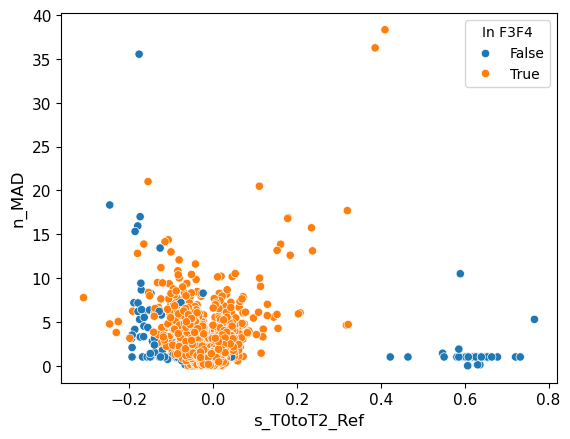

In [372]:
sns.scatterplot(data=s_300_MAD, x='s_T0toT2_Ref', y='n_MAD', hue='In F3F4')

Interestingly / surprisingly, the most extreme outliers among F3F4 mutants are only associated with an intermediate level of resistance. If their deviation is really due to some unseen resistance-conferring secondary mutation, it would likely indicate a mixed population.

Keeping only the F3F4 mutants, are outliers shared within transformation ("Bio") replicates?

In [375]:
s_300_MAD_F3F4 = s_300_MAD[s_300_MAD['In F3F4'] == True].copy().reset_index(drop=True)

<Axes: xlabel='s_T0toT2_Ref', ylabel='n_MAD'>

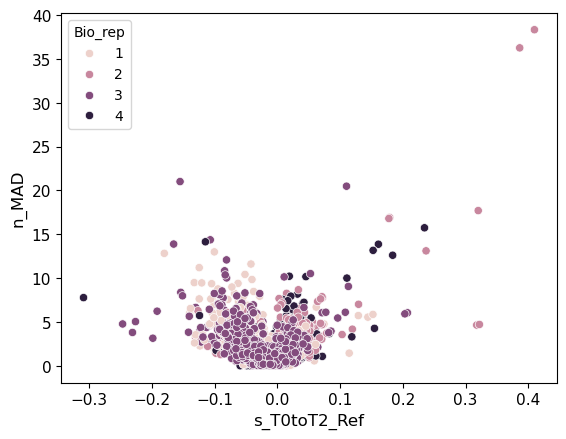

In [376]:
sns.scatterplot(data=s_300_MAD_F3F4, x='s_T0toT2_Ref', y='n_MAD', hue='Bio_rep')

They definitely are, but maybe not as much as initially suspected.

What does the distribution of n_MAD values look like?

In [379]:
# Computing 95th, 97.5 and 99 percentiles
n_MAD_95 = np.nanpercentile(s_300_MAD['n_MAD'], 95)
n_MAD_975 = np.nanpercentile(s_300_MAD['n_MAD'], 97.5)
n_MAD_99 = np.nanpercentile(s_300_MAD['n_MAD'], 99)

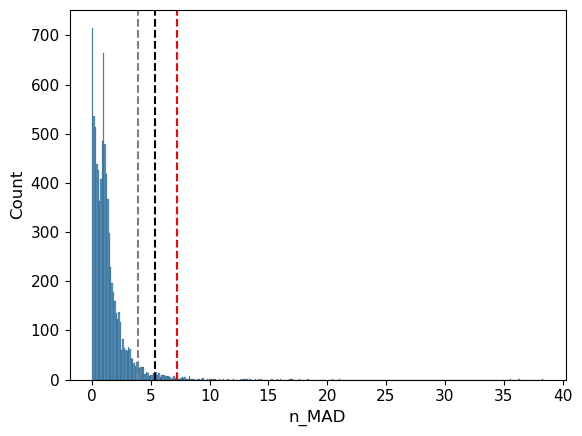

In [380]:
sns.histplot(data=s_300_MAD, x='n_MAD')
plt.axvline(x=n_MAD_95, linestyle='--', c='grey')
plt.axvline(x=n_MAD_975, linestyle='--', c='black')
plt.axvline(x=n_MAD_99, linestyle='--', c='red')

What does the previous plot look like with only replicates with MAD < 3.89?

<Axes: xlabel='s_T0toT2_Ref', ylabel='n_MAD'>

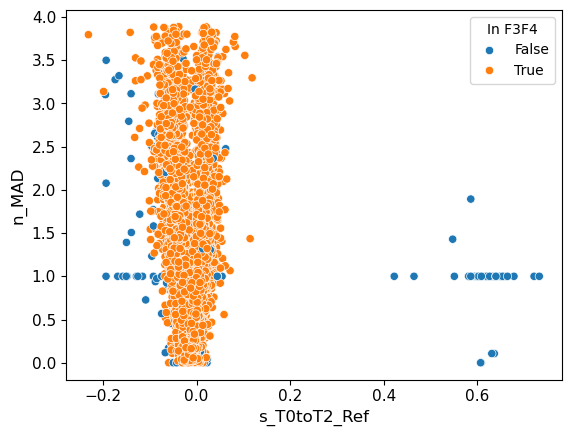

In [382]:
s_300_MAD_filtered = s_300_MAD[s_300_MAD['n_MAD'] <= n_MAD_95].copy().reset_index(drop=True)
s_300_MAD_removed = s_300_MAD[s_300_MAD['n_MAD'] > n_MAD_95].copy().reset_index(drop=True)

sns.scatterplot(data=s_300_MAD_filtered, x='s_T0toT2_Ref', y='n_MAD', hue='In F3F4')

### Is this removal of outliers justified?

#### What fraction of removed outliers are part of a pair of culture replicate observations which are both removed?

For each removed observation, let's check iteratively whether the corresponding culture replicate (same transformation replicate) has also been removed.

In [386]:
s_300_MAD_removed['Pair_removed'] = 'Problem'

for row in range(s_300_MAD_removed.shape[0]):
    current_genotype = s_300_MAD_removed.at[row, 'Genotype']
    current_transfo = s_300_MAD_removed.at[row, 'Bio_rep']
    #current_culture = s_300_MAD_removed.at[row, 'Tech_rep']

    genotype_subset = s_300_MAD_removed[s_300_MAD_removed['Genotype'] == current_genotype].copy().reset_index(drop=True)
    transfo_subset = genotype_subset[genotype_subset['Bio_rep'] == current_transfo].copy().reset_index(drop=True)

    # If the resulting df has two rows, the pair has been removed
    if transfo_subset.shape[0] == 2:
        s_300_MAD_removed.at[row, 'Pair_removed'] = 'Yes'

    elif transfo_subset.shape[0] == 1:
        s_300_MAD_removed.at[row, 'Pair_removed'] = 'No'

    else:
        raise Exception('There should be either one or two observations!')

How often is the full pair removed?

In [388]:
percent_pair = (np.sum(s_300_MAD_removed['Pair_removed'] == 'Yes')/s_300_MAD_removed.shape[0])/100

print(f'{percent_pair}% of removed outliers are part of a pair which is fully removed')

0.0013711583924349883% of removed outliers are part of a pair which is fully removed


This removal of outliers is clearly not adequate, since it almost only removes singletons (and the fraction of pairs is barely improved by using a more stringent threshold).

What we want to remove is outlier selection coefficient estimates due to secondary mutations outside the sequenced region - which would most likely be shared within a transformation replicate. A better approach may be to directly use the absolute deviations from the median, without scaling them relative to MAD (which seems inadequate due to how close to 0 most values are).

### Better approach: performing this outlier removal ONLY for genotypes which have an outlier standard deviation

In [392]:
# Adding the standard deviation to the df
s_mean = s_300_5FC[['Genotype', 'Position', 'In F3F4', 'Mutation type', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'],
                                                                                                as_index=False).mean()
s_mean = s_mean.rename(columns={'s_T0toT2_Ref': 'Mean_s'})

s_std = s_300_5FC[['Genotype', 'Position', 'In F3F4', 'Mutation type', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'],
                                                                                               as_index=False).std()
s_std = s_std.rename(columns={'s_T0toT2_Ref': 'Std_s'})

s_min = s_300_5FC[['Genotype', 'Position', 'In F3F4', 'Mutation type', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'],
                                                                                               as_index=False).min()
s_min = s_min.rename(columns={'s_T0toT2_Ref': 'Min_s'})

s_max = s_300_5FC[['Genotype', 'Position', 'In F3F4', 'Mutation type', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'],
                                                                                               as_index=False).max()
s_max = s_max.rename(columns={'s_T0toT2_Ref': 'Max_s'})

s_out_bypos = pd.merge(s_mean, s_std, on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='outer')
s_out_bypos = pd.merge(s_out_bypos, s_min, on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='outer')
s_out_bypos = pd.merge(s_out_bypos, s_max, on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='outer')

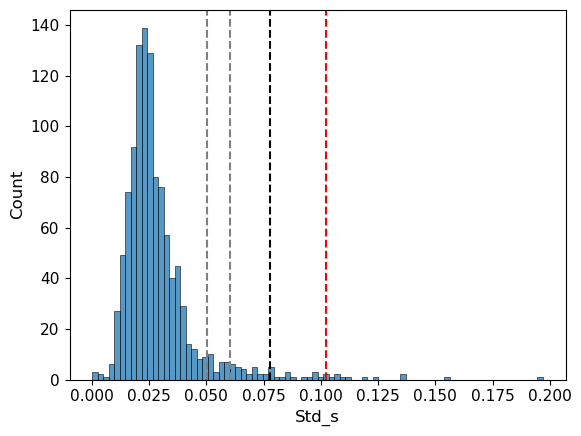

In [393]:
# Plotting the distribution of standard deviations, with 95th, 97.5th and 99th percentiles
std_925 = np.nanpercentile(s_out_bypos['Std_s'], 92.5)
std_95 = np.nanpercentile(s_out_bypos['Std_s'], 95)
std_975 = np.nanpercentile(s_out_bypos['Std_s'], 97.5)
std_99 = np.nanpercentile(s_out_bypos['Std_s'], 99)

sns.histplot(data=s_out_bypos, x='Std_s')
plt.axvline(x=std_925, linestyle='--', c='grey')
plt.axvline(x=std_95, linestyle='--', c='grey')
plt.axvline(x=std_975, linestyle='--', c='black')
plt.axvline(x=std_99, linestyle='--', c='red')

Let's try removing outliers according to n_MAD, but only within the genotypes which have an outlier Std (Top 5%)

In [395]:
out_mut_df = s_out_bypos[s_out_bypos['Std_s'] >= std_95].copy().reset_index(drop=True)
mut_to_filter = out_mut_df['Genotype'].unique()

In [396]:
out_mut_df[out_mut_df['In F3F4'] == True].sort_values(by='Std_s', ascending=False)

Genotype  Position  In F3F4 Mutation type    Mean_s     Std_s  \
9   I-203_1nt_-toG       203     True     Insertion  0.079619  0.196931   
19  S-172_1nt_GtoC       172     True  Substitution  0.086062  0.154201   
54   S-78_1nt_GtoA        78     True  Substitution  0.061398  0.136470   
3   I-109_1nt_-toT       109     True     Insertion  0.030650  0.111915   
14  S-132_1nt_TtoA       132     True  Substitution  0.036523  0.108072   
18  S-160_1nt_TtoC       160     True  Substitution -0.056945  0.107794   
13  S-131_1nt_TtoC       131     True  Substitution -0.032482  0.103781   
6   I-118_1nt_-toC       118     True     Insertion -0.075946  0.098102   
22  S-192_1nt_AtoG       192     True  Substitution  0.030139  0.092088   
4   I-116_1nt_-toC       116     True     Insertion -0.033264  0.086059   
8   I-192_1nt_-toC       192     True     Insertion -0.052768  0.085862   
16  S-143_1nt_AtoG       143     True  Substitution  0.018926  0.078713   
15  S-139_1nt_TtoA       139     True  Substitution  0.012427  0.074856   
55   S-80_1nt_GtoT        80     True  Substitution  0.033378  0.073303   
7   I-129_1nt_-toG       129     True     Insertion -0.033919  0.067192   
17  S-151_1nt_GtoA       151     True  Substitution  0.007090  0.063635   
12  S-126_1nt_TtoG       126     True  Substitution -0.016302  0.063459   
21  S-192_1nt_AtoC       192     True  Substitution -0.006428  0.061881   
5   I-117_1nt_-toT       117     True     Insertion -0.034664  0.061343   

       Min_s     Max_s  
9  -0.038655  0.409794  
19 -0.044888  0.322087  
54 -0.033572  0.320180  
3  -0.051178  0.234505  
14 -0.074953  0.207327  
18 -0.309071  0.025290  
13 -0.246745  0.071618  
6  -0.231032  0.011231  
22 -0.036533  0.178977  
4  -0.191746  0.060830  
8  -0.226220  0.046689  
16 -0.062306  0.154763  
15 -0.037115  0.152605  
55 -0.029226  0.152316  
7  -0.180301  0.020263  
17 -0.034338  0.161020  
12 -0.165369  0.046965  
21 -0.064433  0.129080  
5  -0.155173  0.007731

In [397]:
not_filtered =  s_300_MAD[~s_300_MAD['Genotype'].isin(mut_to_filter)].copy()
to_filter = s_300_MAD[s_300_MAD['Genotype'].isin(mut_to_filter)].copy()
to_filter['To_remove'] = to_filter['n_MAD'] > n_MAD_95

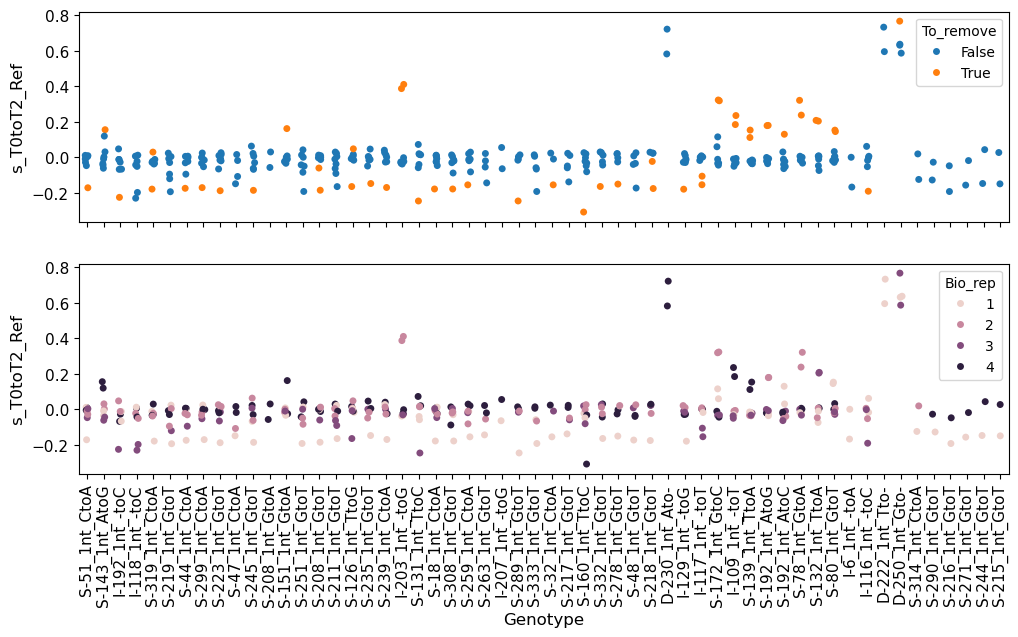

In [398]:
# All variants

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
sns.stripplot(data=to_filter, x='Genotype', y='s_T0toT2_Ref', hue='To_remove', ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=90)

sns.stripplot(data=to_filter, x='Genotype', y='s_T0toT2_Ref', hue='Bio_rep', ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=90)

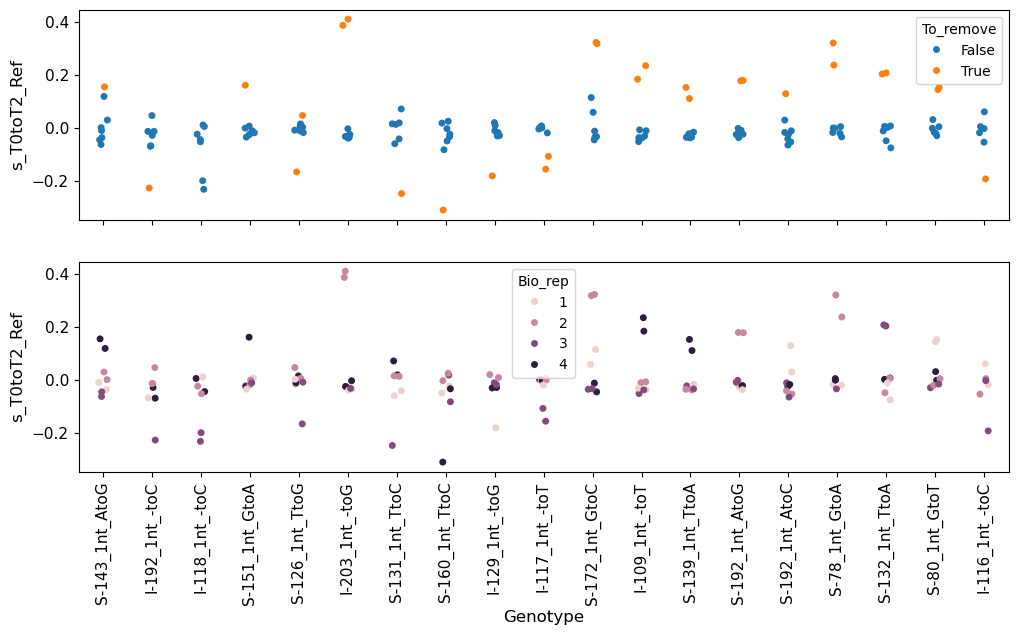

In [399]:
# Only mutations within the F3F4 region

to_filter_F3F4 = to_filter[to_filter['In F3F4'] == True].copy().reset_index(drop=True)

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
sns.stripplot(data=to_filter_F3F4, x='Genotype', y='s_T0toT2_Ref', hue='To_remove', ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=90)

sns.stripplot(data=to_filter_F3F4, x='Genotype', y='s_T0toT2_Ref', hue='Bio_rep', ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=90)

The outlier positive selection coefficients are almost always removed by pair (both culture of the same transformation), so this seems to work as intended!

When negative selection coefficients are identified as outliers, they almost always come from the same sequencing library (one culture of 3 when within F3F4, and one culture of 1 when outside of it). These outliers thus seem to be due to sequencing variation.

In [402]:
# Assembling the dataset WITHOUT outliers
out_filtered = to_filter[to_filter['To_remove'] == False].copy().reset_index(drop=True)
out_filtered = out_filtered.drop(columns=['To_remove'])
s_no_out = pd.concat([not_filtered, out_filtered]).reset_index(drop=True)

### Final estimations of fitness effects

#### Let's first plot the selection coefficients for all mutations (only F3F4 region) 

In [405]:
# Recomputing the medians, + min and max s for each genotype
# The 'To_ignore' samples are now ignored
s_ignored = s_no_out[s_no_out['To_ignore'] == False].copy().reset_index(drop=True)

median_s = s_ignored[['Genotype', 's_T0toT2_Ref']].groupby(by='Genotype', as_index=False).median()
median_s = median_s.rename(columns={'s_T0toT2_Ref': 'Median_s_ignored'})
min_s = s_ignored[['Genotype', 's_T0toT2_Ref']].groupby(by='Genotype', as_index=False).min()
min_s = min_s.rename(columns={'s_T0toT2_Ref': 'Min_s_ignored'})
max_s = s_ignored[['Genotype', 's_T0toT2_Ref']].groupby(by='Genotype', as_index=False).max()
max_s = max_s.rename(columns={'s_T0toT2_Ref': 'Max_s_ignored'})

s_no_out = pd.merge(s_no_out, median_s, on=['Genotype'], how='left')
s_no_out = pd.merge(s_no_out, min_s, on=['Genotype'], how='left')
s_no_out = pd.merge(s_no_out, max_s, on=['Genotype'], how='left')

In [406]:
# Converting the mutation position and adding a column specifying the new base
s_no_out['FCY1_position'] = s_no_out['Position'] - 205 + 1*(s_no_out['Mutation type'] == 'Insertion')
s_no_out['New_nt'] = s_no_out['Genotype'].apply(lambda x: x.split('to')[1])
# 1 is added in the case of insertions, because their positions where initially defined as
# "the base to the right of which the nt is inserted", rather than the position of
# the inserted nt

In [407]:
# Version of the df without duplicates
s_medians = s_no_out.drop(columns=['Alias', 'Bio_rep', 'Tech_rep', 'To_ignore', 'N_T0', 'N_T3', 's_T0toT1_Ref', 's_T0toT2_Ref',
                                   's_T0toT3_Ref', 'Abs_med_s_T0toT2', 'MAD_s_T0toT2', 'n_MAD']).copy()
s_medians = s_medians.drop_duplicates().reset_index(drop=True)

In [408]:
# Defining a palette for the different types of mutations
mut_palette = {'Substitution': cm.tab10.colors[9], 
               'Insertion': cm.tab20b.colors[1],
               'Deletion': cm.tab10.colors[3]}

In [409]:
# Individually plotting all the selection coefficients
s_F3F4 = s_no_out[s_no_out['In F3F4'] == True].copy().reset_index(drop=True)
s_F3F4 = s_F3F4[s_F3F4['To_ignore'] == False].copy().reset_index(drop=True)

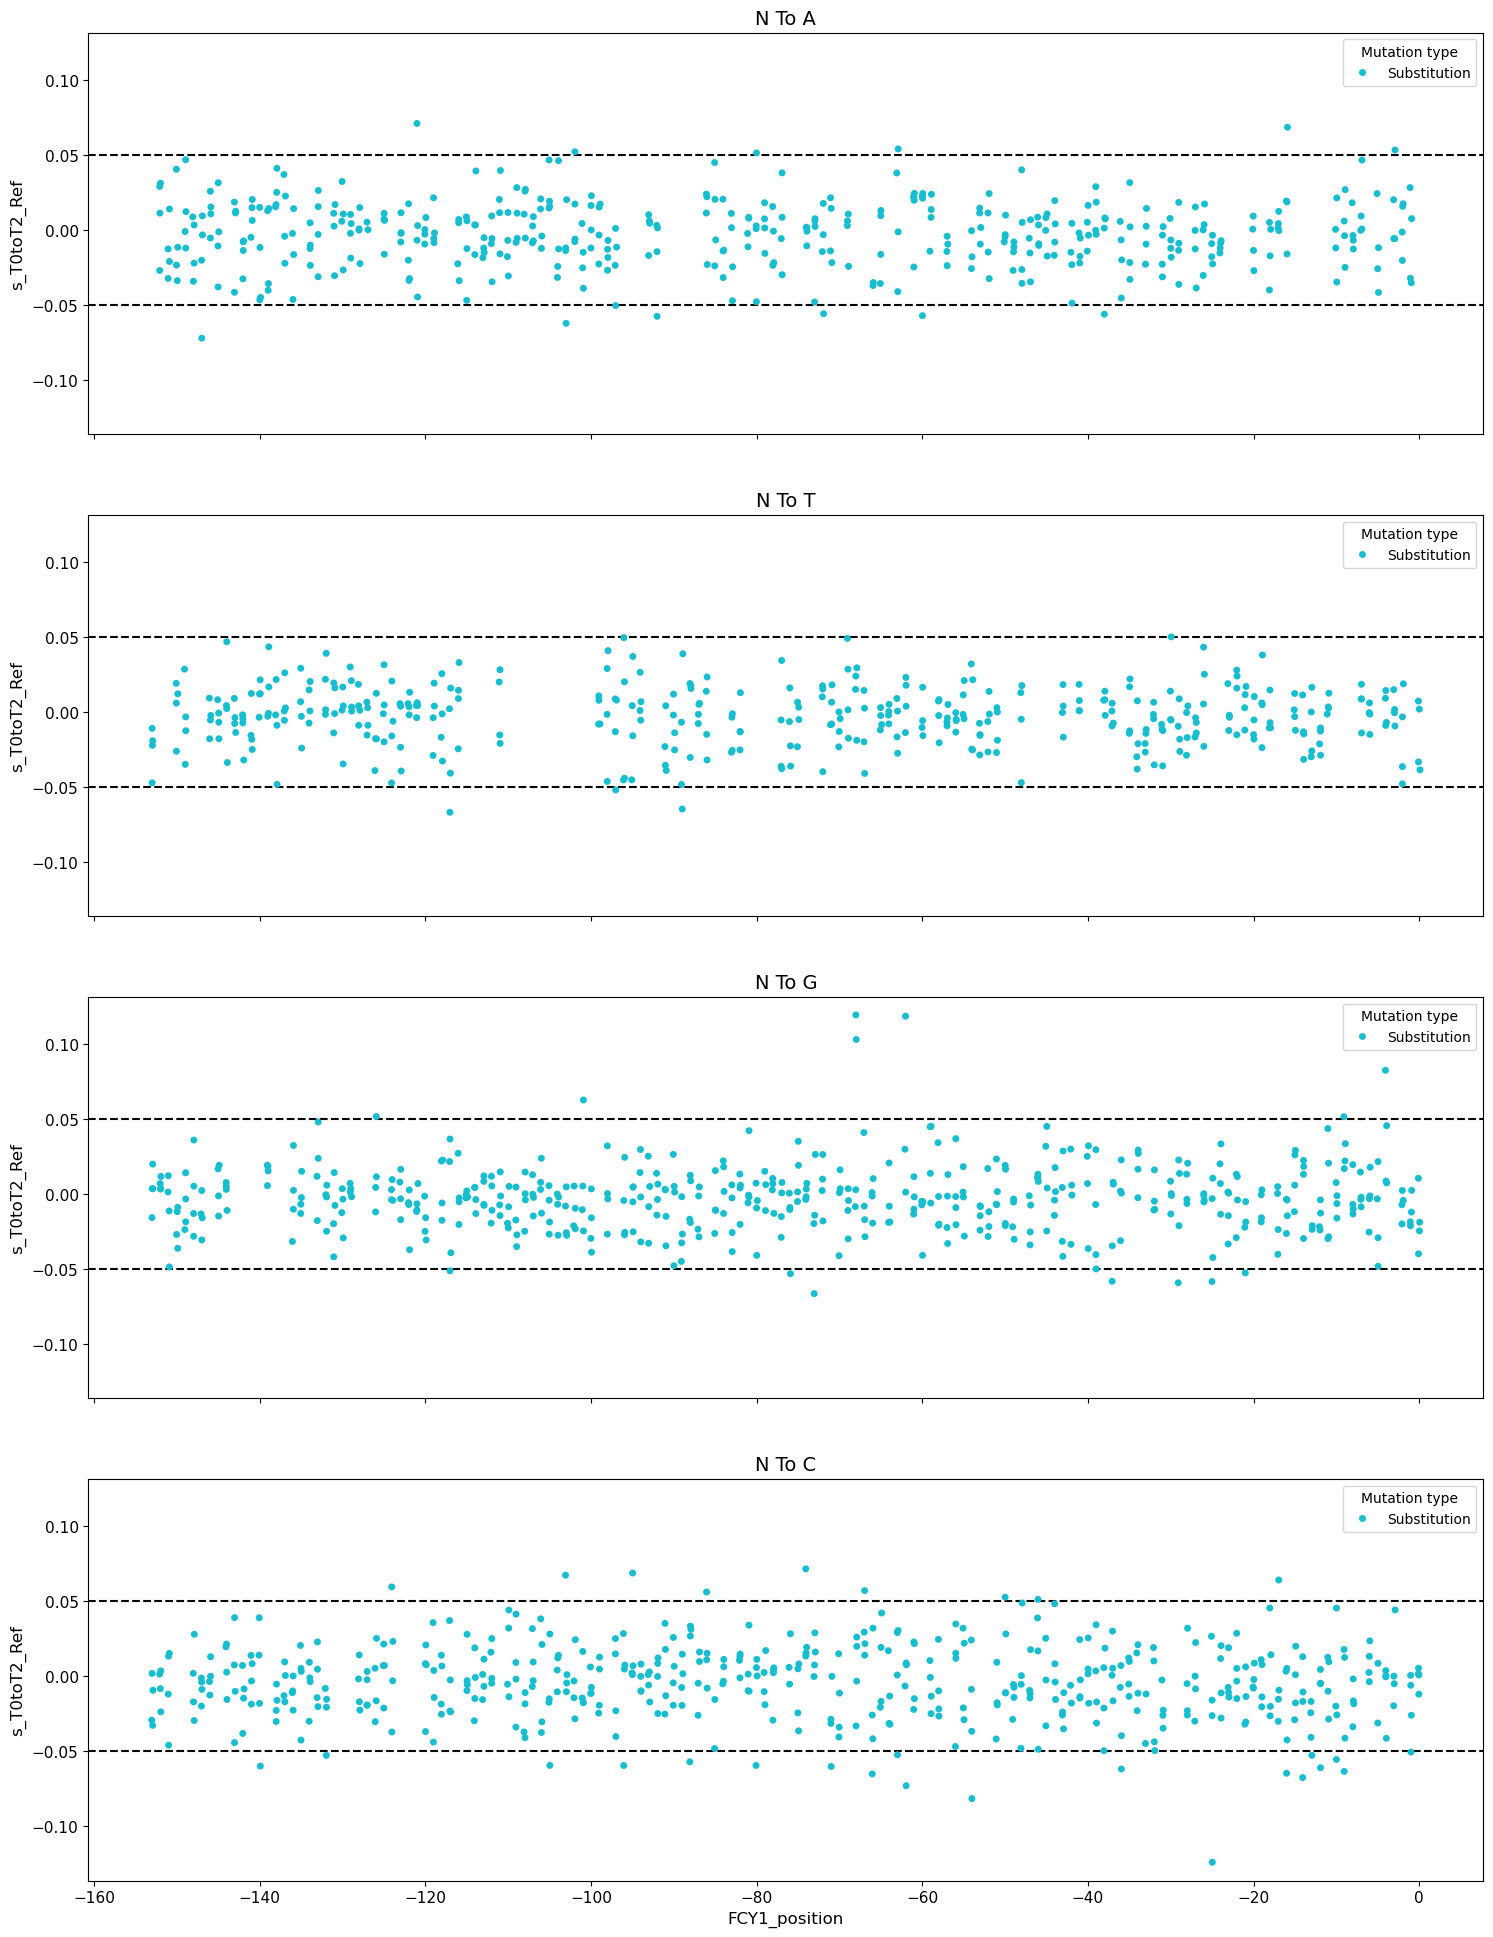

In [410]:
# First figure: Substitutions
# from top to bottom: A, T, G, C

s_F3F4_sub = s_F3F4[s_F3F4['Mutation type'] == 'Substitution'].copy().reset_index(drop=True)

fig, axs = plt.subplots(4, 1, figsize=(18, 24), sharex=True, sharey=True)

sns.stripplot(data=s_F3F4_sub[s_F3F4_sub['New_nt'] == 'A'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[0], palette=mut_palette, native_scale=True)
axs[0].set_title('N To A', fontsize=14)

sns.stripplot(data=s_F3F4_sub[s_F3F4_sub['New_nt'] == 'T'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[1], palette=mut_palette, native_scale=True)
axs[1].set_title('N To T', fontsize=14)


sns.stripplot(data=s_F3F4_sub[s_F3F4_sub['New_nt'] == 'G'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[2], palette=mut_palette, native_scale=True)
axs[2].set_title('N To G', fontsize=14)

sns.stripplot(data=s_F3F4_sub[s_F3F4_sub['New_nt'] == 'C'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[3], palette=mut_palette, native_scale=True)
axs[3].set_title('N To C', fontsize=14)

for k in range(4):
    axs[k].axhline(y=0.05, linestyle='--', c='black')
    axs[k].axhline(y=-0.05, linestyle='--', c='black')

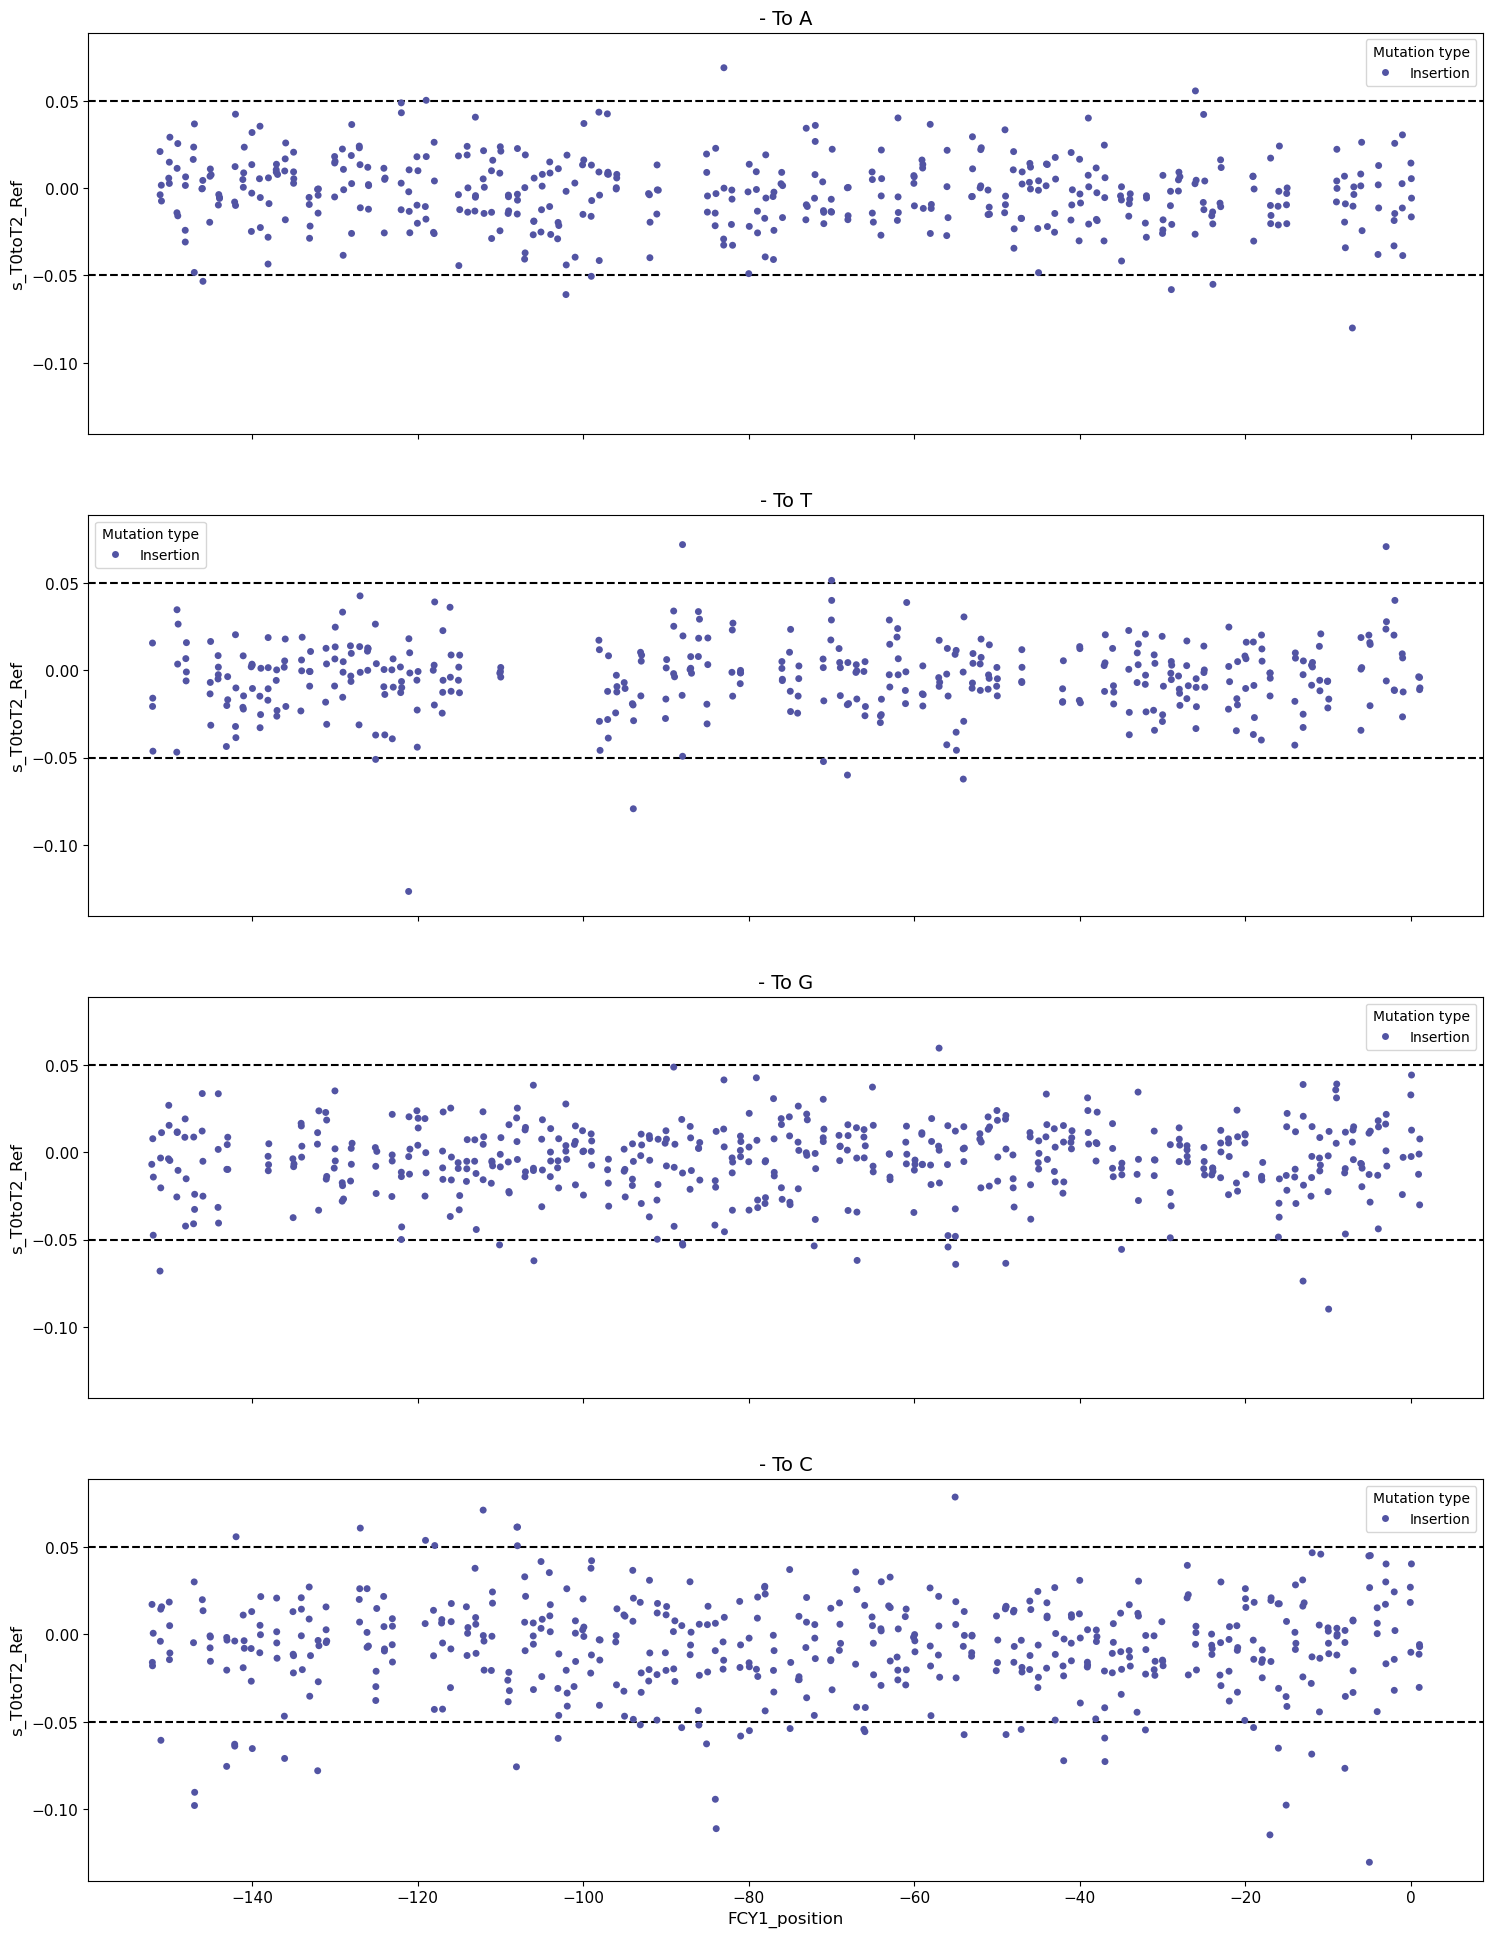

In [411]:
# Second figure: Insertions
# from top to bottom: A, T, G, C

s_F3F4_ins = s_F3F4[s_F3F4['Mutation type'] == 'Insertion'].copy().reset_index(drop=True)

fig, axs = plt.subplots(4, 1, figsize=(18, 24), sharex=True, sharey=True)

sns.stripplot(data=s_F3F4_ins[s_F3F4_ins['New_nt'] == 'A'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[0], palette=mut_palette, native_scale=True)
axs[0].set_title('- To A', fontsize=14)

sns.stripplot(data=s_F3F4_ins[s_F3F4_ins['New_nt'] == 'T'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[1], palette=mut_palette, native_scale=True)
axs[1].set_title('- To T', fontsize=14)


sns.stripplot(data=s_F3F4_ins[s_F3F4_ins['New_nt'] == 'G'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[2], palette=mut_palette, native_scale=True)
axs[2].set_title('- To G', fontsize=14)

sns.stripplot(data=s_F3F4_ins[s_F3F4_ins['New_nt'] == 'C'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[3], palette=mut_palette, native_scale=True)
axs[3].set_title('- To C', fontsize=14)

for k in range(4):
    axs[k].axhline(y=0.05, linestyle='--', c='black')
    axs[k].axhline(y=-0.05, linestyle='--', c='black')

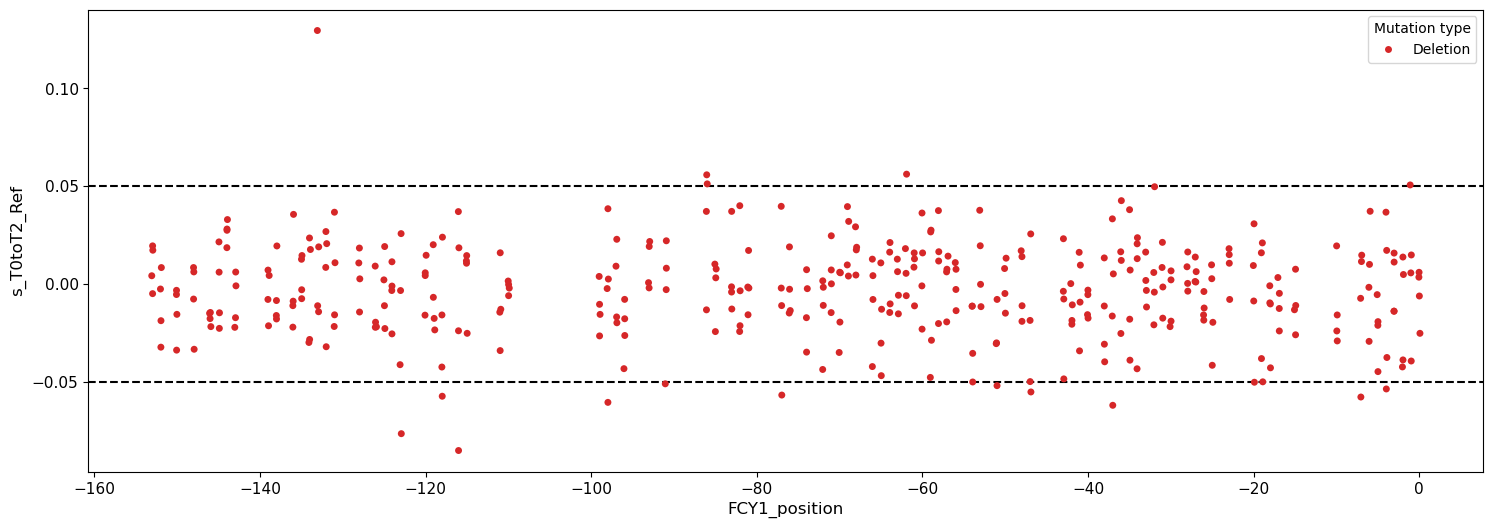

In [412]:
# Third figure: Deletions

s_F3F4_del = s_F3F4[s_F3F4['Mutation type'] == 'Deletion'].copy().reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(18, 6), sharex=True, sharey=True)

sns.stripplot(data=s_F3F4_del, x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=ax, palette=mut_palette, native_scale=True)

ax.axhline(y=0.05, linestyle='--', c='black')
ax.axhline(y=-0.05, linestyle='--', c='black')

We seem to have great coverage of the mutations of interest - even after the filtering steps. There is also no clear indication that any of the mutation has an effect (significantly different from 0).

It seems like we would have been able to measure confidently any fitness difference of 5% or more, which is a good resolution. There were, however, no such effects in this experiment.

#### Testing if there are significant ("measurable") fitness effects

Now that an outlier removal step has been performed, we can use a t-test (with Benjamini-Hochberg correction at FDR=5%) to assess whether some mutations have significant fitness effects

In [417]:
s_med_F3F4 = s_medians[s_medians['In F3F4'] == True].copy().reset_index(drop=True)

In [418]:
s_med_F3F4['not_zero_p-val'] = np.nan
s_med_F3F4['n_observed'] = np.nan

for row in range(s_med_F3F4.shape[0]):
    current_mut = s_med_F3F4.at[row, 'Genotype']
    data_subset = s_F3F4[s_F3F4['Genotype'] == current_mut].copy().reset_index(drop=True)
    n_obs = data_subset.shape[0]
    s_med_F3F4.at[row, 'n_observed'] = n_obs
    t_test = stats.ttest_1samp(data_subset['s_T0toT2_Ref'], 0, nan_policy='omit')
    s_med_F3F4.at[row, 'not_zero_p-val'] = t_test.pvalue

In [419]:
s_med_F3F4['not_zero_FDR'] = stats.false_discovery_control(s_med_F3F4['not_zero_p-val'])

In [420]:
s_med_F3F4.sort_values(by=['not_zero_FDR'], ascending=True)

Genotype  Position  In F3F4 Mutation type  Median_s_T0toT2  \
513  I-140_1nt_-toT       140     True     Insertion        -0.022816   
1     I-67_1nt_-toA        67     True     Insertion        -0.000571   
2     D-59_1nt_Gto-        59     True      Deletion        -0.019759   
532  I-180_1nt_-toG       180     True     Insertion        -0.011995   
254   D-61_1nt_Ato-        61     True      Deletion         0.001359   
..              ...       ...      ...           ...              ...   
406   I-71_1nt_-toT        71     True     Insertion        -0.004986   
358  S-134_1nt_GtoA       134     True  Substitution         0.000176   
334   S-74_1nt_CtoA        74     True  Substitution         0.001546   
375   S-57_1nt_TtoG        57     True  Substitution        -0.007346   
756   S-85_1nt_TtoC        85     True  Substitution        -0.036000   

     Median_s_ignored  Min_s_ignored  Max_s_ignored  FCY1_position New_nt  \
513         -0.025800      -0.030021      -0.016626            -64      T   
1            0.009769       0.007787       0.013634           -137      A   
2           -0.016360      -0.021801      -0.014580           -146      -   
532         -0.010097      -0.012988      -0.008976            -24      G   
254          0.027710       0.018515       0.032863           -144      -   
..                ...            ...            ...            ...    ...   
406         -0.000757      -0.009159       0.010681           -133      T   
358          0.000176      -0.021771       0.021452            -71      A   
334          0.006809      -0.030532       0.016905           -131      A   
375         -0.003824      -0.028146       0.036037           -148      G   
756          0.007983      -0.036979       0.020833           -120      C   

     not_zero_p-val  n_observed  not_zero_FDR  
513        0.003218         4.0      0.497047  
1          0.003880         4.0      0.497047  
2          0.001897         4.0      0.497047  
532        0.001493         4.0      0.497047  
254        0.002961         4.0      0.497047  
..              ...         ...           ...  
406        0.999617         4.0      0.999833  
358        0.999404         4.0      0.999833  
334        0.999833         4.0      0.999833  
375        0.996770         4.0      0.999833  
756        0.997377         4.0      0.999833  

[1020 rows x 13 columns]

In [421]:
s_med_F3F4[s_med_F3F4['not_zero_FDR'] < 0.92]

Genotype  Position  In F3F4 Mutation type  Median_s_T0toT2  \
0      I-94_1nt_-toT        94     True     Insertion        -0.003158   
1      I-67_1nt_-toA        67     True     Insertion        -0.000571   
2      D-59_1nt_Gto-        59     True      Deletion        -0.019759   
4     I-149_1nt_-toG       149     True     Insertion        -0.029170   
7      S-65_1nt_GtoA        65     True  Substitution        -0.028250   
...              ...       ...      ...           ...              ...   
1010  S-192_1nt_AtoC       192     True  Substitution        -0.020639   
1015  S-139_1nt_TtoA       139     True  Substitution        -0.021184   
1016  I-109_1nt_-toT       109     True     Insertion        -0.020587   
1017  S-143_1nt_AtoG       143     True  Substitution        -0.004311   
1018  S-151_1nt_GtoA       151     True  Substitution        -0.014307   

      Median_s_ignored  Min_s_ignored  Max_s_ignored  FCY1_position New_nt  \
0            -0.001221      -0.003958       0.001537           -110      T   
1             0.009769       0.007787       0.013634           -137      A   
2            -0.016360      -0.021801      -0.014580           -146      -   
4            -0.040280      -0.064148       0.012103            -55      G   
7            -0.028370      -0.046612       0.015024           -140      A   
...                ...            ...            ...            ...    ...   
1010         -0.032607      -0.052809      -0.016874            -13      C   
1015         -0.036124      -0.037115      -0.035132            -66      A   
1016         -0.008808      -0.010495      -0.007121            -95      T   
1017          0.029946       0.001279       0.118685            -62      G   
1018         -0.017948      -0.025815      -0.000522            -54      A   

      not_zero_p-val  n_observed  not_zero_FDR  
0           0.363973         4.0      0.916193  
1           0.003880         4.0      0.497047  
2           0.001897         4.0      0.497047  
4           0.136732         4.0      0.902337  
7           0.231346         4.0      0.915612  
...              ...         ...           ...  
1010        0.025120         4.0      0.902337  
1015        0.017470         2.0      0.902337  
1016        0.120498         2.0      0.902337  
1017        0.292952         3.0      0.915612  
1018        0.186914         3.0      0.912212  

[416 rows x 13 columns]

In [422]:
s_med_F3F4[s_med_F3F4['not_zero_p-val'] < 0.05].sort_values(by='not_zero_p-val')

Genotype  Position  In F3F4 Mutation type  Median_s_T0toT2  \
532   I-180_1nt_-toG       180     True     Insertion        -0.011995   
654   S-159_1nt_TtoG       159     True  Substitution         0.009672   
2      D-59_1nt_Gto-        59     True      Deletion        -0.019759   
254    D-61_1nt_Ato-        61     True      Deletion         0.001359   
513   I-140_1nt_-toT       140     True     Insertion        -0.022816   
409    I-75_1nt_-toG        75     True     Insertion        -0.022937   
1      I-67_1nt_-toA        67     True     Insertion        -0.000571   
766    I-95_1nt_-toC        95     True     Insertion        -0.032812   
449   S-181_1nt_TtoA       181     True  Substitution        -0.007950   
490   I-186_1nt_-toG       186     True     Insertion        -0.015244   
628   S-172_1nt_GtoT       172     True  Substitution        -0.021576   
454   I-186_1nt_-toC       186     True     Insertion        -0.020464   
601    I-60_1nt_-toA        60     True     Insertion        -0.007821   
934   S-162_1nt_AtoC       162     True  Substitution        -0.022220   
1015  S-139_1nt_TtoA       139     True  Substitution        -0.021184   
858   I-134_1nt_-toT       134     True     Insertion         0.022918   
783    S-66_1nt_CtoG        66     True  Substitution        -0.006925   
71    I-188_1nt_-toG       188     True     Insertion        -0.030777   
810    S-92_1nt_TtoA        92     True  Substitution        -0.014264   
743   S-193_1nt_AtoT       193     True  Substitution        -0.013137   
106   I-167_1nt_-toC       167     True     Insertion        -0.059362   
221    S-67_1nt_GtoA        67     True  Substitution         0.021772   
1010  S-192_1nt_AtoC       192     True  Substitution        -0.020639   
843   S-196_1nt_TtoG       196     True  Substitution         0.028645   
615   D-179_1nt_Cto-       179     True      Deletion        -0.014094   
199   S-107_1nt_CtoA       107     True  Substitution        -0.013851   
132   I-118_1nt_-toT       118     True     Insertion         0.013030   
511   S-152_1nt_CtoT       152     True  Substitution        -0.015355   
452   I-205_1nt_-toT       205     True     Insertion        -0.010652   
209    S-97_1nt_TtoC        97     True  Substitution        -0.023858   
438   S-156_1nt_TtoA       156     True  Substitution        -0.024320   
1009  S-192_1nt_AtoG       192     True  Substitution        -0.014705   
421   S-152_1nt_CtoG       152     True  Substitution        -0.016575   
117   I-195_1nt_-toG       195     True     Insertion         0.021574   
804    I-84_1nt_-toG        84     True     Insertion         0.009078   
754   I-101_1nt_-toC       101     True     Insertion        -0.039426   
81     S-67_1nt_GtoC        67     True  Substitution        -0.019476   
523   S-178_1nt_GtoT       178     True  Substitution        -0.016537   
436   D-137_1nt_Ato-       137     True      Deletion        -0.008720   
609   I-176_1nt_-toT       176     True     Insertion        -0.020140   
842   S-193_1nt_AtoG       193     True  Substitution        -0.027326   
880    I-95_1nt_-toA        95     True     Insertion        -0.011526   
581    S-53_1nt_TtoG        53     True  Substitution        -0.003374   
793   D-154_1nt_Ato-       154     True      Deletion        -0.030299   
890   I-198_1nt_-toG       198     True     Insertion        -0.014984   
543   I-194_1nt_-toT       194     True     Insertion        -0.018174   
914   S-138_1nt_AtoC       138     True  Substitution         0.003115   
207    S-55_1nt_CtoG        55     True  Substitution        -0.016976   
533   I-163_1nt_-toG       163     True     Insertion        -0.006134   
550   I-153_1nt_-toA       153     True     Insertion        -0.012943   

      Median_s_ignored  Min_s_ignored  Max_s_ignored  FCY1_position New_nt  \
532          -0.010097      -0.012988      -0.008976            -24      G   
654           0.011017       0.008458       0.013268            -46      G   
2  

Not even one selection coefficient is significantly different from 0 at FDR = 0.05!

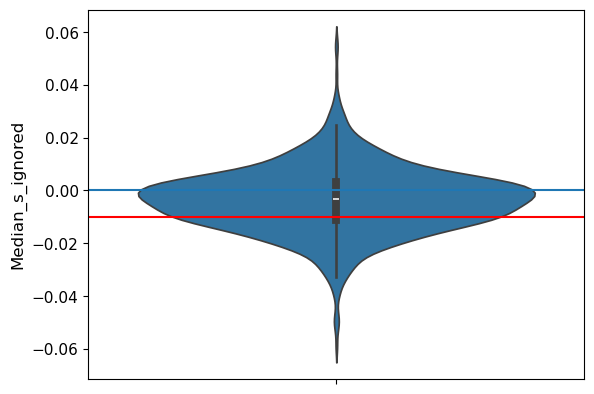

In [424]:
sns.violinplot(s_med_F3F4['Median_s_ignored'])
plt.axhline(y=0)
plt.axhline(y=-0.01, c='red')

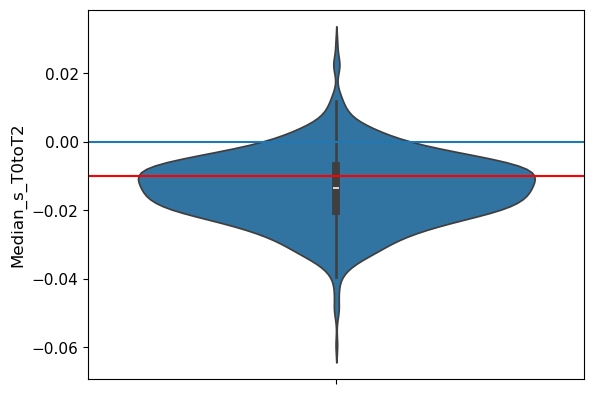

In [425]:
sns.violinplot(s_med_F3F4['Median_s_T0toT2'])
plt.axhline(y=0)
plt.axhline(y=-0.01, c='red')

The shift observed between the two medians s seem to justify ignoring the four 'to_ignore' samples

## Exporting the data (paired-end 300 selection coefficients, with 5-FC)

In [428]:
# Median s for F3F4 mutations, with p-values (t-test to see if diff from 0)
s_med_F3F4.to_csv("Supp_data/median_s_F3F4.csv", index=False)

# Final data, per library (only 5-FC and no spike-ins)
s_no_out.to_csv("Supp_data/s_300_5FC_no_out.csv", index=False)

## Are selection coefficients obtained with spike-ins comparable?

In [430]:
# Taking only the data for F3F4 sequencing WITH spikes-ins and 5-FC
s_300_spikes = s_filter_300[(s_filter_300['Condition'] == 'WITH_5FC') & (s_filter_300['With_CDS_spikeins'] == True)].copy().reset_index(drop=True)

Computing medians and corresponding absolute deviations and MAD, for each genotype

In [432]:
# Computing the median s for each genotype
s_medians_spikes = s_300_spikes[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'N_T0', 'N_T3', 's_T0toT1_Ref', 's_T0toT2_Ref',
                                 's_T0toT3_Ref']].copy().groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).median()

s_medians_spikes = s_medians_spikes.rename(columns={'s_T0toT2_Ref': 'Median_s_T0toT2'})

In [433]:
# Preparing the dataframe for the MAD
s_MAD_spikes = s_300_spikes[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'Alias', 'Bio_rep', 'Tech_rep',
                             'To_ignore', 'N_T0', 'N_T3', 's_T0toT1_Ref', 's_T0toT2_Ref', 's_T0toT3_Ref']].copy()

# Adding the medians
s_MAD_spikes = pd.merge(s_MAD_spikes, s_medians_spikes[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'Median_s_T0toT2']],
                        on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='left')

# Computing the absolute deviation from the median, and then the MAD
s_MAD_spikes['Abs_med_s_T0toT2'] = np.abs(s_MAD_spikes['s_T0toT2_Ref'] - s_MAD_spikes['Median_s_T0toT2'])

s_MAD_calc = s_MAD_spikes[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'Abs_med_s_T0toT2']].copy()
s_MAD_calc = s_MAD_calc.groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).median()
s_MAD_calc = s_MAD_calc.rename(columns={'Abs_med_s_T0toT2': 'MAD_s_T0toT2'})
s_MAD_spikes = pd.merge(s_MAD_spikes, s_MAD_calc, on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='left')

# For each estimate, converting each abs deviation into a number of MADs
s_MAD_spikes['n_MAD'] = s_MAD_spikes['Abs_med_s_T0toT2'] / s_MAD_spikes['MAD_s_T0toT2']

Adding standard deviation for each genotype

In [435]:
# Adding the standard deviation to the df
s_std = s_300_spikes[['Genotype', 'Position', 'In F3F4', 'Mutation type', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).std()
s_std = s_std.rename(columns={'s_T0toT2_Ref': 'Std_s'})

s_min = s_300_spikes[['Genotype', 'Position', 'In F3F4', 'Mutation type', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).min()
s_min = s_min.rename(columns={'s_T0toT2_Ref': 'Min_s'})

s_max = s_300_spikes[['Genotype', 'Position', 'In F3F4', 'Mutation type', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).max()
s_max = s_max.rename(columns={'s_T0toT2_Ref': 'Max_s'})

s_bypos_spikes = pd.merge(s_std, s_min, on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='outer')
s_bypos_spikes = pd.merge(s_bypos_spikes, s_max, on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='outer')

### Looking at the distributions

1) Standard deviation by genotype

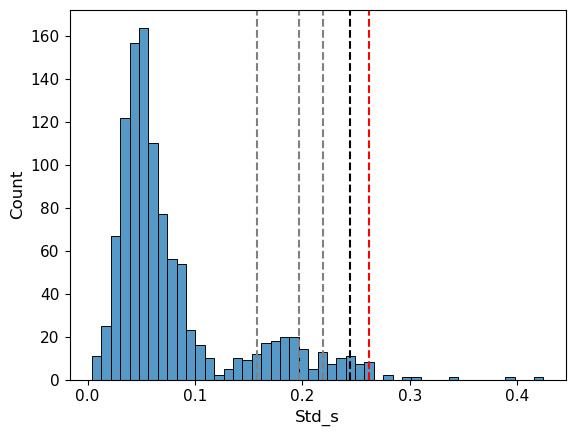

In [438]:
# Plotting the distribution of standard deviations, with 95th, 97.5th and 99th percentiles
std_85_sp = np.nanpercentile(s_bypos_spikes['Std_s'], 85)
std_925_sp = np.nanpercentile(s_bypos_spikes['Std_s'], 92.5)
std_95_sp = np.nanpercentile(s_bypos_spikes['Std_s'], 95)
std_975_sp = np.nanpercentile(s_bypos_spikes['Std_s'], 97.5)
std_99_sp = np.nanpercentile(s_bypos_spikes['Std_s'], 99)

sns.histplot(data=s_bypos_spikes, x='Std_s')
plt.axvline(x=std_85_sp, linestyle='--', c='grey')
plt.axvline(x=std_925_sp, linestyle='--', c='grey')
plt.axvline(x=std_95_sp, linestyle='--', c='grey')
plt.axvline(x=std_975_sp, linestyle='--', c='black')
plt.axvline(x=std_99_sp, linestyle='--', c='red')

We might need to be more stringent here and consider all genotypes above the 85th percentile as potential outliers, for the filtering to be comparable.

2. nMAD by s estimate

In [441]:
# Computing 95th, 97.5 and 99 percentiles
n_MAD_85_sp = np.nanpercentile(s_MAD_spikes['n_MAD'], 85)
n_MAD_95_sp = np.nanpercentile(s_MAD_spikes['n_MAD'], 95)
n_MAD_975_sp = np.nanpercentile(s_MAD_spikes['n_MAD'], 97.5)
n_MAD_99_sp = np.nanpercentile(s_MAD_spikes['n_MAD'], 99)

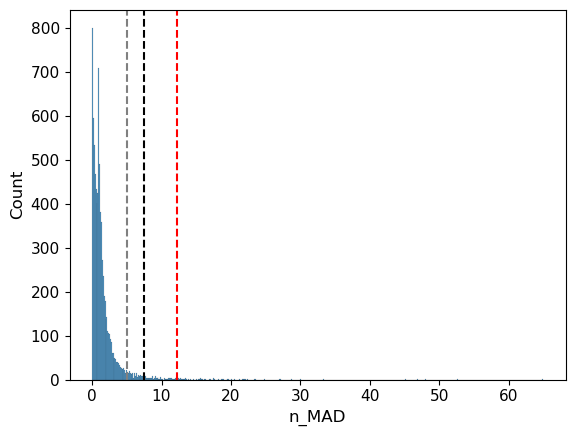

In [442]:
sns.histplot(data=s_MAD_spikes, x='n_MAD')
#plt.axvline(x=n_MAD_85_sp, linestyle='--', c='grey')
plt.axvline(x=n_MAD_95_sp, linestyle='--', c='grey')
plt.axvline(x=n_MAD_975_sp, linestyle='--', c='black')
plt.axvline(x=n_MAD_99_sp, linestyle='--', c='red')

There is no need to be more stringent in the filtering of estimates within each genotype. The 95th percentile will still be used as threshold.

### Filtering out outlier measurements

Within genotypes with standard deviation >= 85th percentile, datapoints with MAD >= 95th percentile are removed

In [446]:
# Selecting genotypes on which the filtering must be applied
out_df_spikes = s_bypos_spikes[s_bypos_spikes['Std_s'] >= std_85_sp].copy().reset_index(drop=True)
mut_to_filter_sp = out_df_spikes['Genotype'].unique()

In [447]:
# Identifying the datapoints to remove
not_filtered_sp =  s_MAD_spikes[~s_MAD_spikes['Genotype'].isin(mut_to_filter_sp)].copy()
to_filter_spikes = s_MAD_spikes[s_MAD_spikes['Genotype'].isin(mut_to_filter_sp)].copy()
to_filter_spikes['To_remove'] = to_filter_spikes['n_MAD'] > n_MAD_95_sp

Plotting the outliers to be filtered out

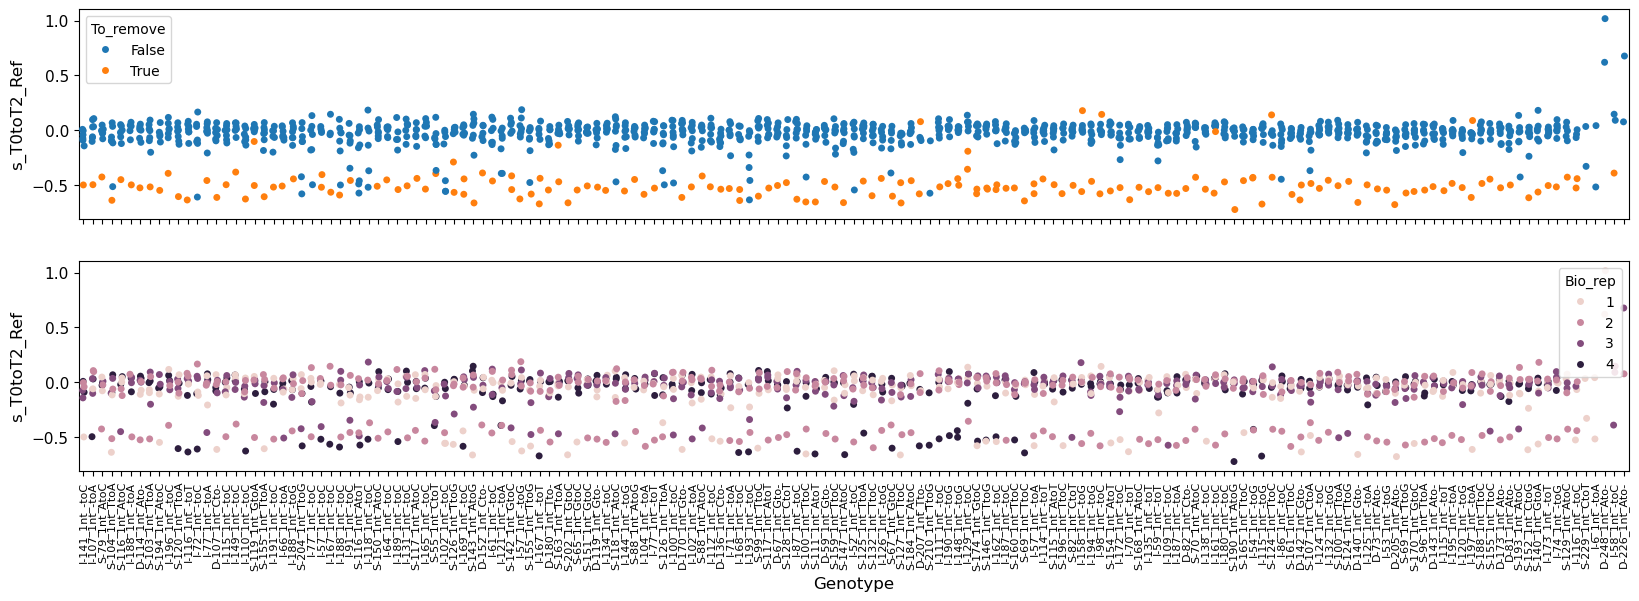

In [449]:
# All variants

fig, axs = plt.subplots(2, 1, figsize=(20, 6), sharex=True)
sns.stripplot(data=to_filter_spikes, x='Genotype', y='s_T0toT2_Ref', hue='To_remove', ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=90)

sns.stripplot(data=to_filter_spikes, x='Genotype', y='s_T0toT2_Ref', hue='Bio_rep', ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)

We are mostly removing spurious highly deleterious effects. There does not seem to be artifactually beneficial mutations in this dataset.

Culture replicates of the same transformation are not as ofter removed as a pair. Usually, only one measurement is an outlier.

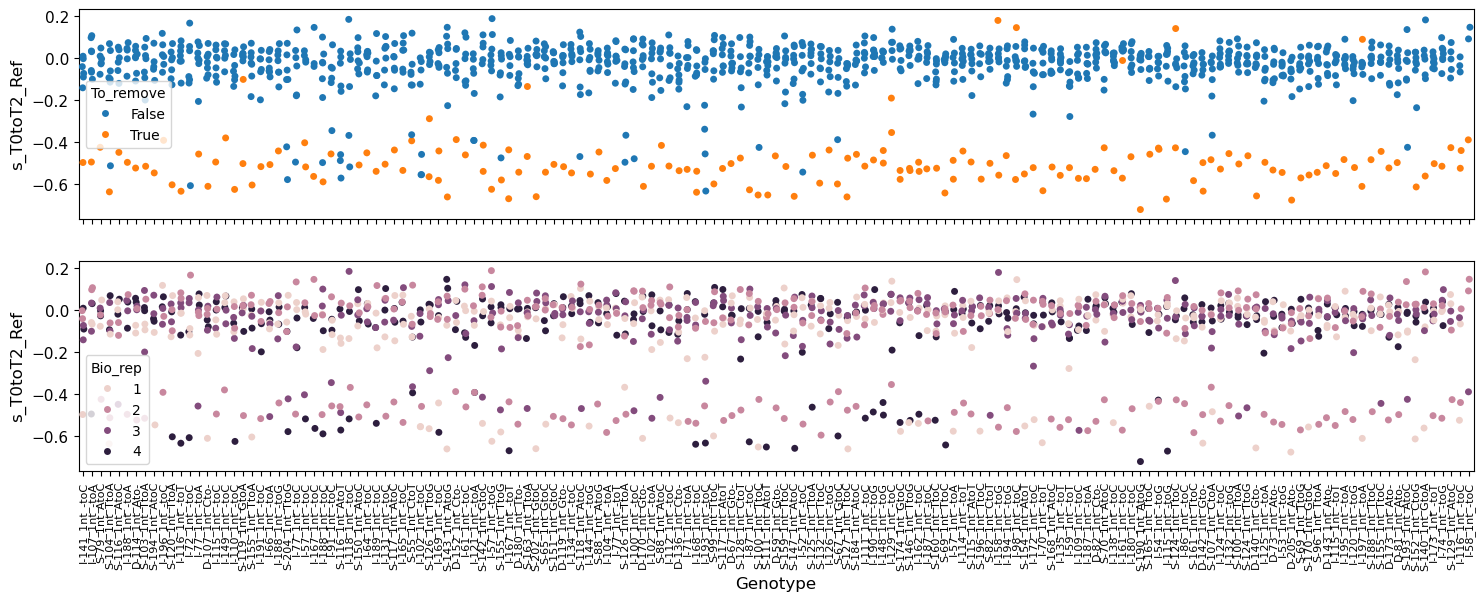

In [452]:
# Only mutations within the F3F4 region

to_filter_F3F4_sp = to_filter_spikes[to_filter_spikes['In F3F4'] == True].copy().reset_index(drop=True)

fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharex=True)
sns.stripplot(data=to_filter_F3F4_sp, x='Genotype', y='s_T0toT2_Ref', hue='To_remove', ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=90)

sns.stripplot(data=to_filter_F3F4_sp, x='Genotype', y='s_T0toT2_Ref', hue='Bio_rep', ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)

Assembling the dataset without outliers

In [454]:
out_filtered_sp = to_filter_spikes[to_filter_spikes['To_remove'] == False].copy().reset_index(drop=True)
out_filtered_sp = out_filtered_sp.drop(columns=['To_remove'])
s_no_out_sp = pd.concat([not_filtered_sp, out_filtered_sp]).reset_index(drop=True)

### Comparing the estimated selection coefficients

#### Is the F3F4 data qualitatively similar?

Let's plot all non-outlier selection coefficients, as done previously

In [458]:
# Computing min and max s for each genotype
min_s_sp = s_no_out_sp[['Genotype', 's_T0toT2_Ref']].groupby(by='Genotype', as_index=False).min()
min_s_sp = min_s_sp.rename(columns={'s_T0toT2_Ref': 'Min_s'})
max_s_sp = s_no_out_sp[['Genotype', 's_T0toT2_Ref']].groupby(by='Genotype', as_index=False).max()
max_s_sp = max_s_sp.rename(columns={'s_T0toT2_Ref': 'Max_s'})

s_no_out_sp = pd.merge(s_no_out_sp, min_s_sp, on=['Genotype'], how='left')
s_no_out_sp = pd.merge(s_no_out_sp, max_s_sp, on=['Genotype'], how='left')

In [459]:
# Converting the mutation position and adding a column specifying the new base
s_no_out_sp['FCY1_position'] = s_no_out_sp['Position'] - 205 + 1*(s_no_out_sp['Mutation type'] == 'Insertion')
s_no_out_sp['New_nt'] = s_no_out_sp['Genotype'].apply(lambda x: x.split('to')[1])

In [460]:
# Version of the df without duplicates
s_medians_sp = s_no_out_sp.drop(columns=['Alias', 'Bio_rep', 'Tech_rep', 'N_T0', 'N_T3', 's_T0toT1_Ref', 's_T0toT2_Ref',
                                         's_T0toT3_Ref', 'Abs_med_s_T0toT2', 'MAD_s_T0toT2', 'n_MAD']).copy()
s_medians_sp = s_medians_sp.drop_duplicates().reset_index(drop=True)

In [461]:
# Individually plotting all the selection coefficients
s_F3F4_sp = s_no_out_sp[s_no_out_sp['In F3F4'] == True].copy().reset_index(drop=True)

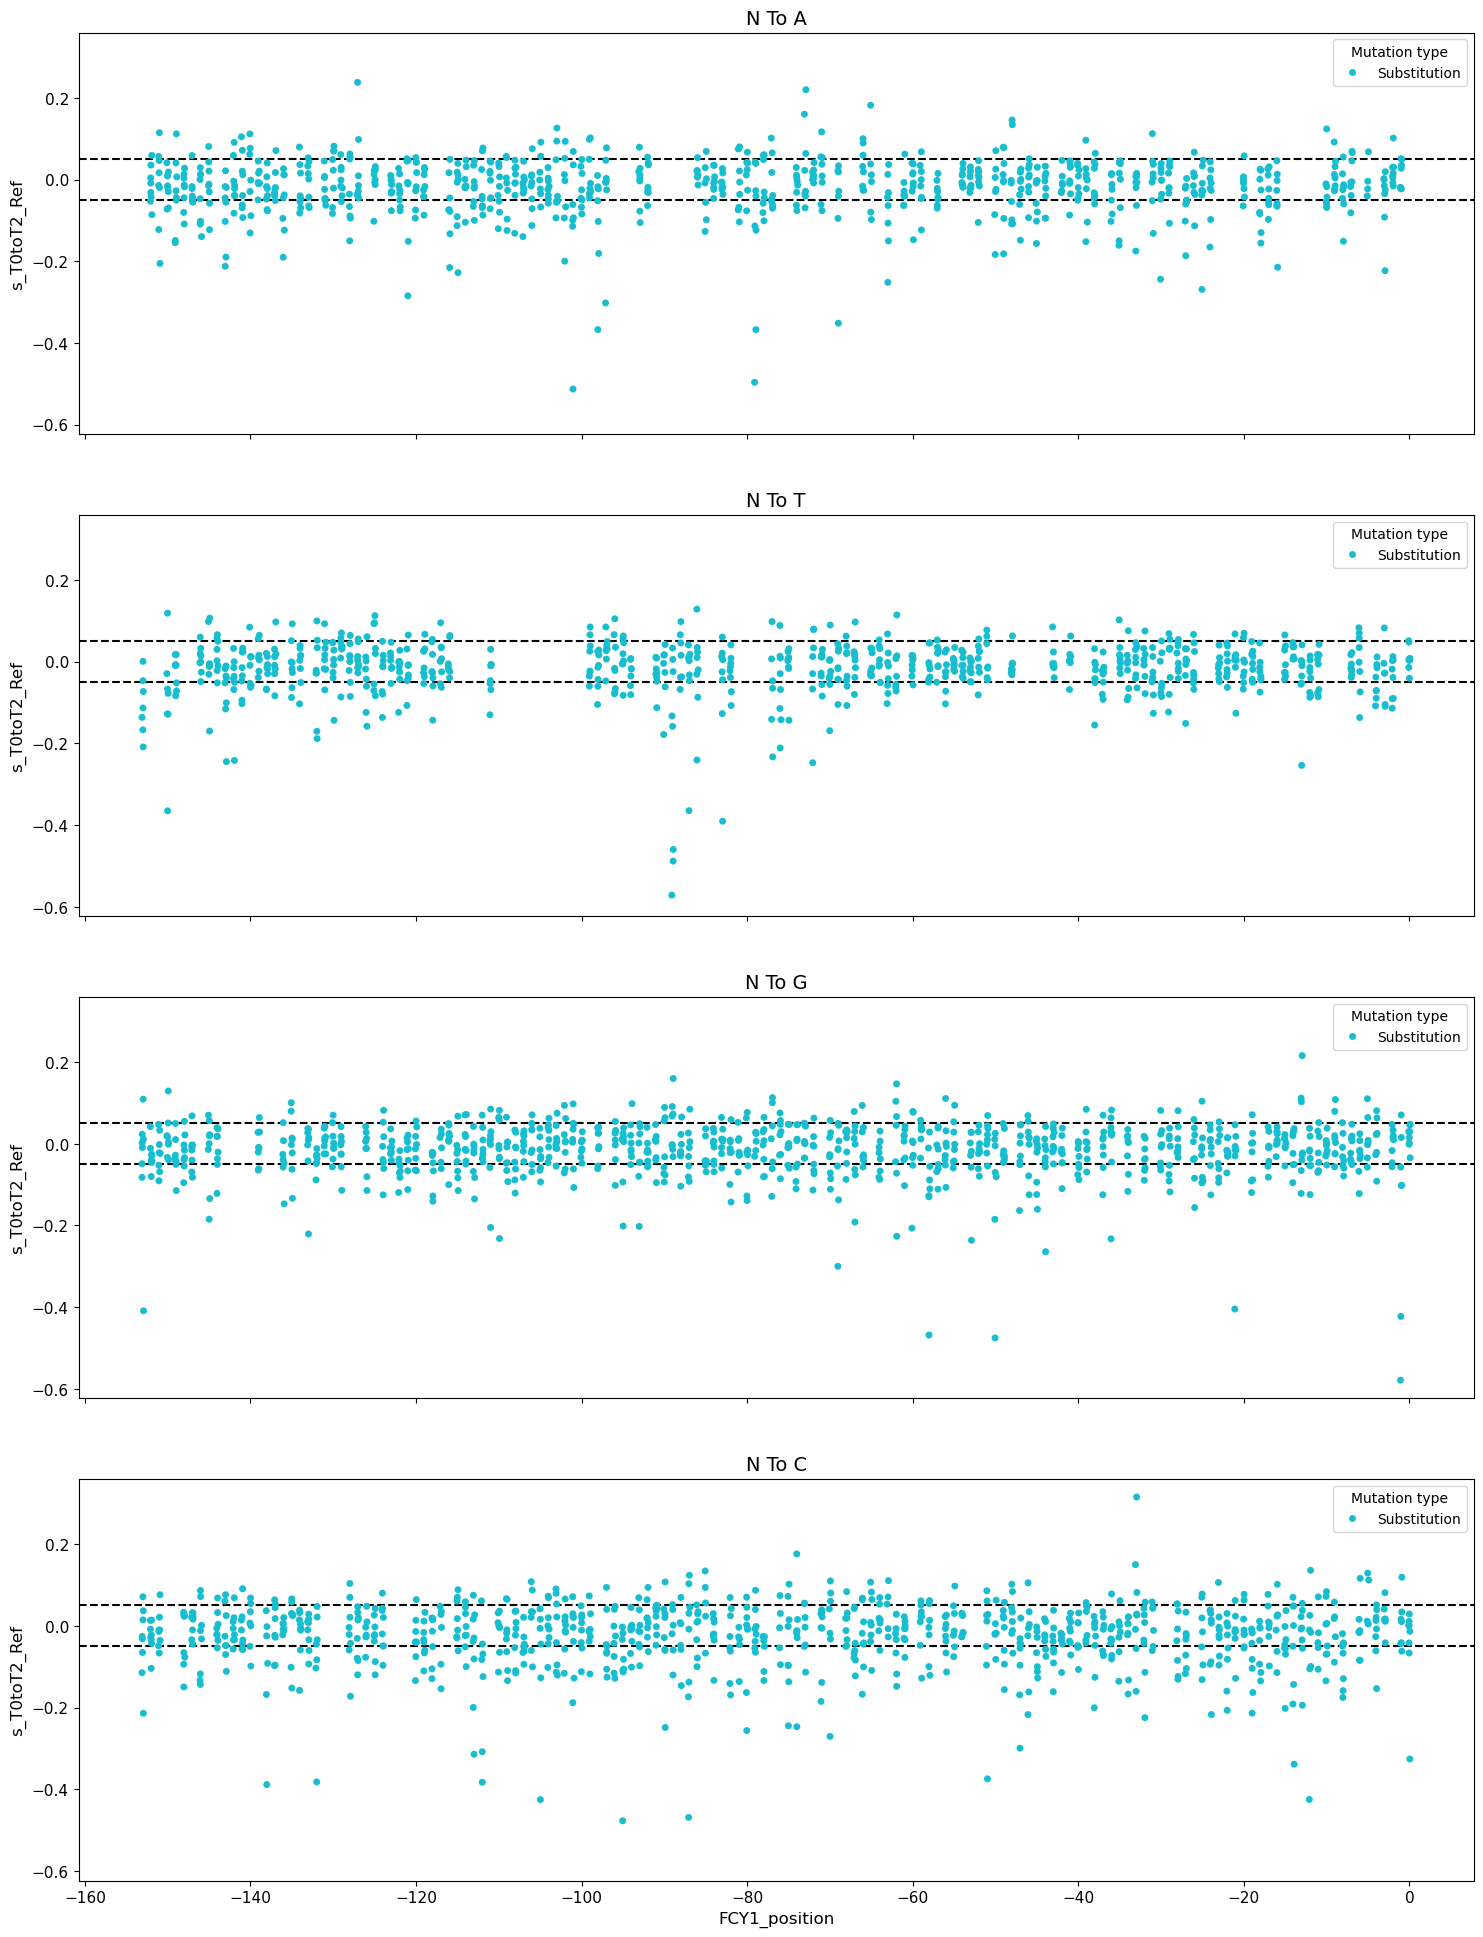

In [462]:
# First figure: Substitutions
# from top to bottom: A, T, G, C

s_F3F4_sub = s_F3F4_sp[s_F3F4_sp['Mutation type'] == 'Substitution'].copy().reset_index(drop=True)

fig, axs = plt.subplots(4, 1, figsize=(18, 24), sharex=True, sharey=True)

sns.stripplot(data=s_F3F4_sub[s_F3F4_sub['New_nt'] == 'A'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[0], palette=mut_palette, native_scale=True)
axs[0].set_title('N To A', fontsize=14)

sns.stripplot(data=s_F3F4_sub[s_F3F4_sub['New_nt'] == 'T'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[1], palette=mut_palette, native_scale=True)
axs[1].set_title('N To T', fontsize=14)


sns.stripplot(data=s_F3F4_sub[s_F3F4_sub['New_nt'] == 'G'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[2], palette=mut_palette, native_scale=True)
axs[2].set_title('N To G', fontsize=14)

sns.stripplot(data=s_F3F4_sub[s_F3F4_sub['New_nt'] == 'C'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[3], palette=mut_palette, native_scale=True)
axs[3].set_title('N To C', fontsize=14)

for k in range(4):
    axs[k].axhline(y=0.05, linestyle='--', c='black')
    axs[k].axhline(y=-0.05, linestyle='--', c='black')

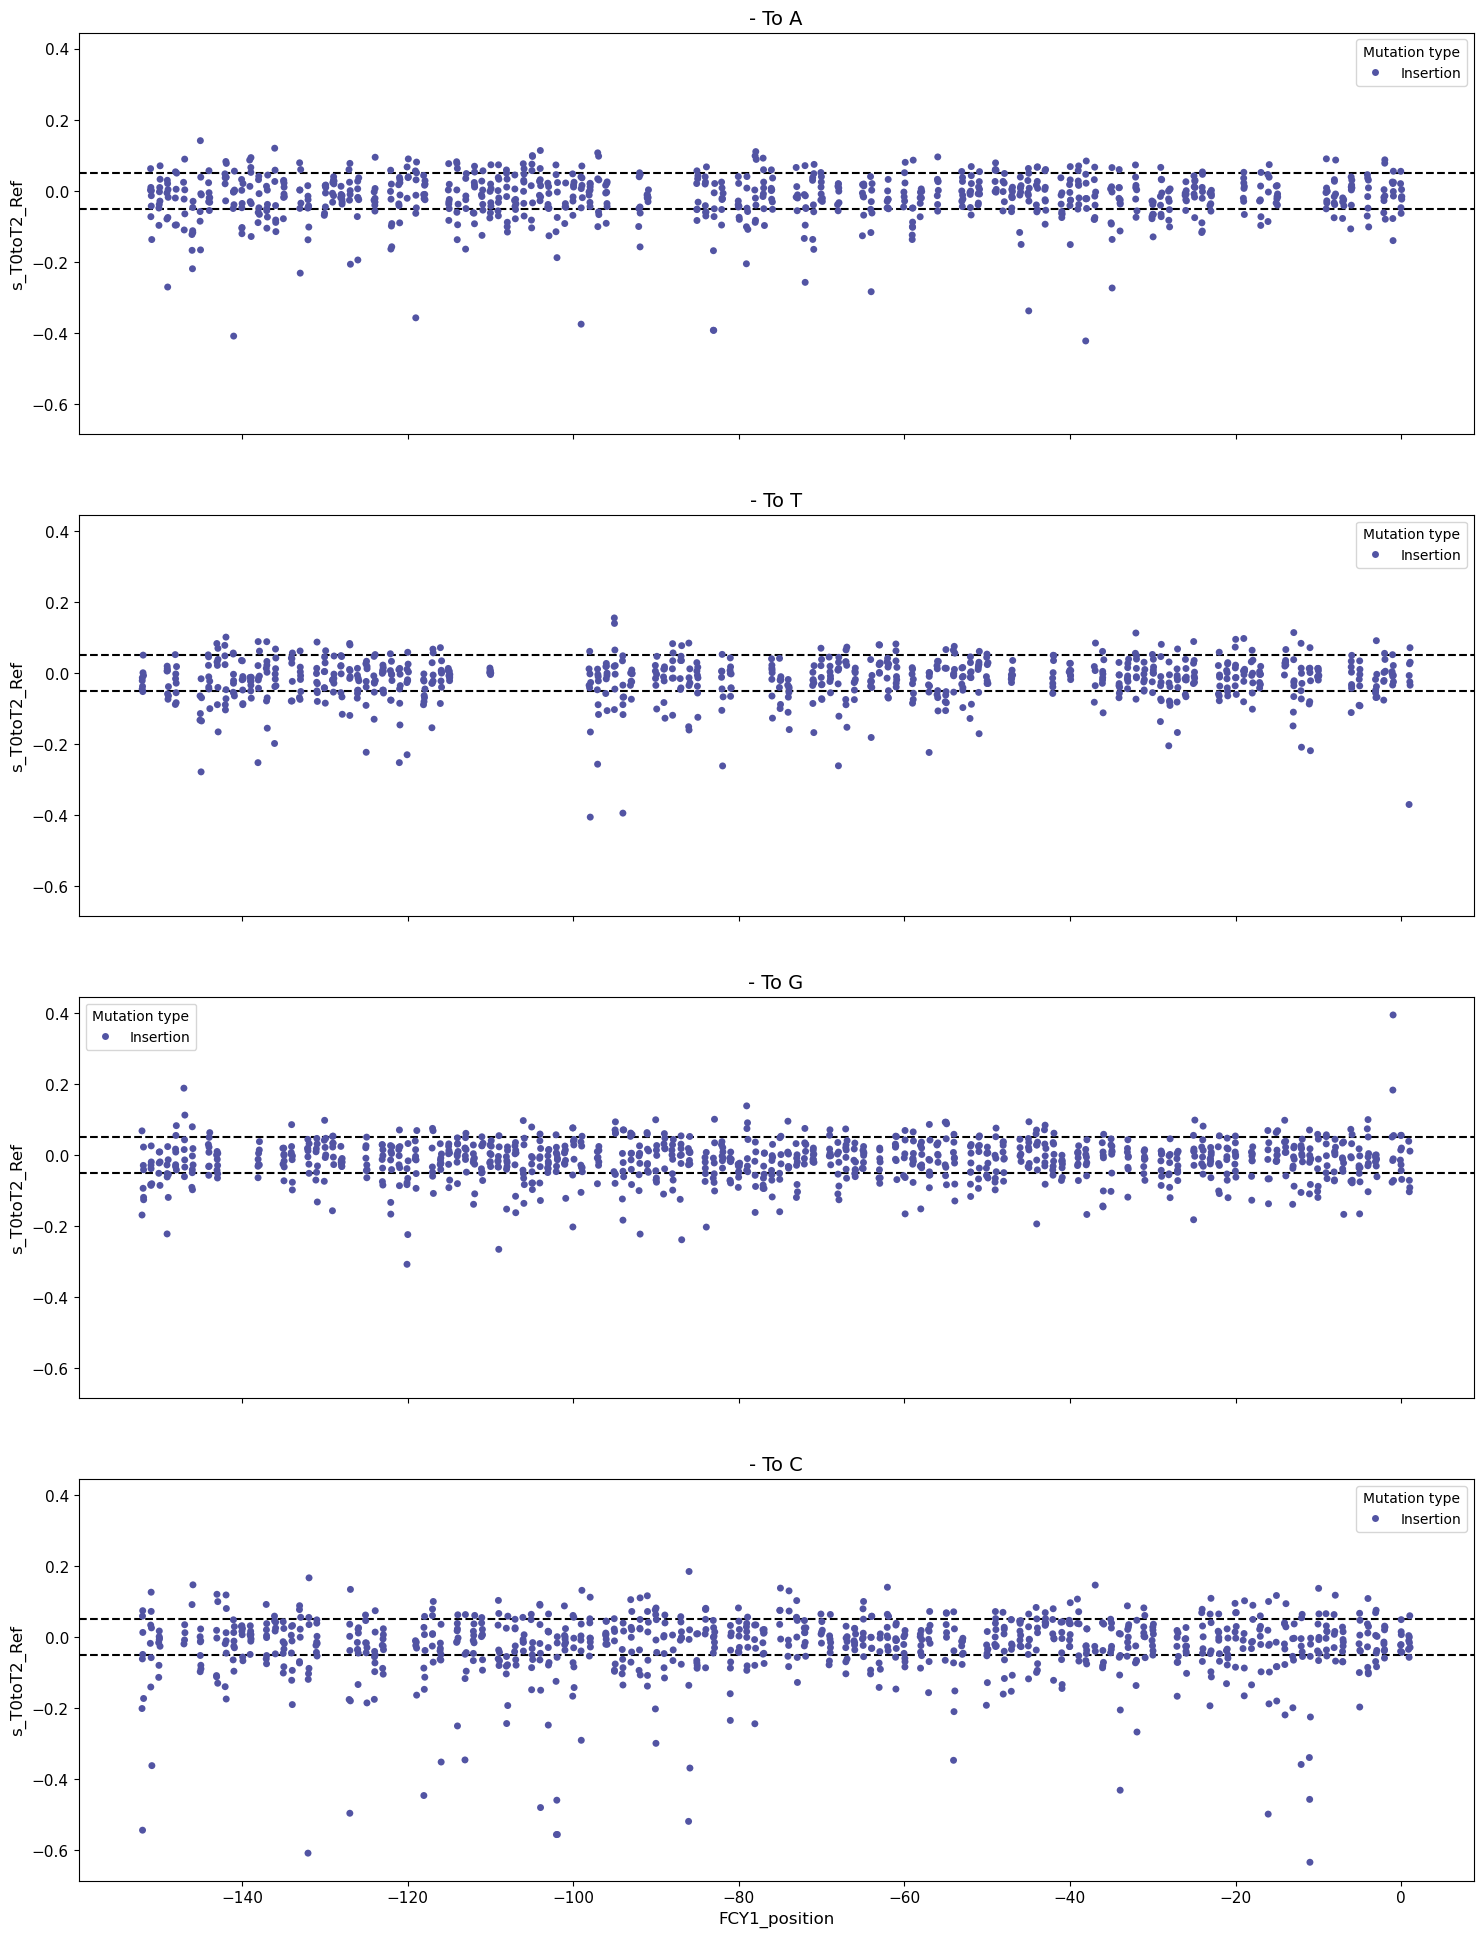

In [463]:
# Second figure: Insertions
# from top to bottom: A, T, G, C

s_F3F4_ins = s_F3F4_sp[s_F3F4_sp['Mutation type'] == 'Insertion'].copy().reset_index(drop=True)

fig, axs = plt.subplots(4, 1, figsize=(18, 24), sharex=True, sharey=True)

sns.stripplot(data=s_F3F4_ins[s_F3F4_ins['New_nt'] == 'A'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[0], palette=mut_palette, native_scale=True)
axs[0].set_title('- To A', fontsize=14)

sns.stripplot(data=s_F3F4_ins[s_F3F4_ins['New_nt'] == 'T'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[1], palette=mut_palette, native_scale=True)
axs[1].set_title('- To T', fontsize=14)


sns.stripplot(data=s_F3F4_ins[s_F3F4_ins['New_nt'] == 'G'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[2], palette=mut_palette, native_scale=True)
axs[2].set_title('- To G', fontsize=14)

sns.stripplot(data=s_F3F4_ins[s_F3F4_ins['New_nt'] == 'C'].copy(), x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=axs[3], palette=mut_palette, native_scale=True)
axs[3].set_title('- To C', fontsize=14)

for k in range(4):
    axs[k].axhline(y=0.05, linestyle='--', c='black')
    axs[k].axhline(y=-0.05, linestyle='--', c='black')

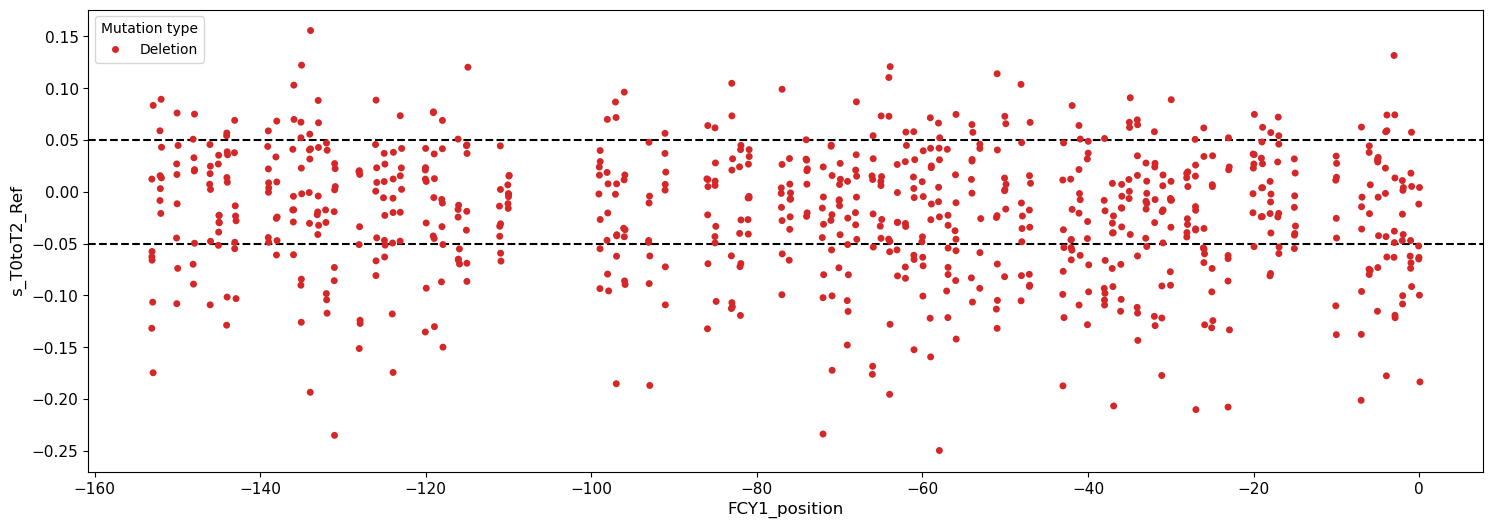

In [464]:
# Third figure: Deletions
# from top to bottom: A, T, G, C

s_F3F4_del = s_F3F4_sp[s_F3F4_sp['Mutation type'] == 'Deletion'].copy().reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(18, 6), sharex=True, sharey=True)

sns.stripplot(data=s_F3F4_del, x='FCY1_position', y='s_T0toT2_Ref',
             hue='Mutation type', ax=ax, palette=mut_palette, native_scale=True)

ax.axhline(y=0.05, linestyle='--', c='black')
ax.axhline(y=-0.05, linestyle='--', c='black')

There is more variance and many outliers (both negative and positive) remain, but the data is qualitatively similar!

#### How are selection coefficients from the two types of samples correlated?

Using the medians (**calculated before the removal of outliers**)

In [468]:
# Merging the data
medians_merged = pd.merge(s_medians, s_medians_sp, on=['Genotype', 'Position', 'In F3F4', 'Mutation type',
                                                      'FCY1_position', 'New_nt'], how='outer', suffixes=('', '_Spikes'))

Text(0.5, 1.0, 'Only F3-F4 variants')

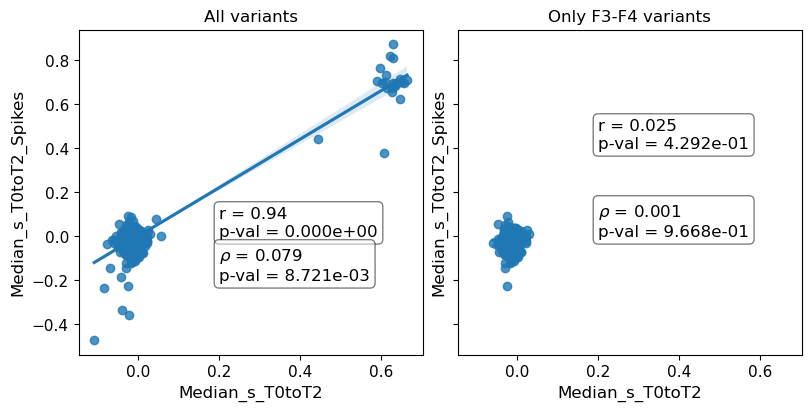

In [469]:
# For the OLS selection coefficients
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True,
                       sharex=True, sharey=True)
# Left panel: All variants
all_sub = medians_merged.copy().dropna(subset=['Median_s_T0toT2', 'Median_s_T0toT2_Spikes']).reset_index(drop=True)

sns.regplot(data=all_sub, x='Median_s_T0toT2', y='Median_s_T0toT2_Spikes', ax=axs[0])

pearson_coeff = stats.pearsonr(all_sub['Median_s_T0toT2'], all_sub['Median_s_T0toT2_Spikes'])

axs[0].annotate(r"r = "f'{round(pearson_coeff[0], 3)}\np-val = {pearson_coeff[1]:.3e}',
                     (0.2, 0), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)
    
spearman_coeff = stats.spearmanr(all_sub['Median_s_T0toT2'], all_sub['Median_s_T0toT2_Spikes'])
axs[0].annotate(r"$\rho$ = "f'{round(spearman_coeff[0], 3)}\np-val = {spearman_coeff[1]:.3e}',
                     (0.2, -0.2), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)
axs[0].set_title('All variants')

# Right panel: Only F3F4
F3F4_sub = medians_merged[medians_merged['In F3F4'] == True].copy().dropna(subset=['Median_s_T0toT2', 'Median_s_T0toT2_Spikes']).reset_index(drop=True)

sns.regplot(data=F3F4_sub, x='Median_s_T0toT2', y='Median_s_T0toT2_Spikes', ax=axs[1])

pearson_coeff = stats.pearsonr(F3F4_sub['Median_s_T0toT2'], F3F4_sub['Median_s_T0toT2_Spikes'])

axs[1].annotate(r"r = "f'{round(pearson_coeff[0], 3)}\np-val = {pearson_coeff[1]:.3e}',
                     (0.2, 0.4), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)
    
spearman_coeff = stats.spearmanr(F3F4_sub['Median_s_T0toT2'], F3F4_sub['Median_s_T0toT2_Spikes'])
axs[1].annotate(r"$\rho$ = "f'{round(spearman_coeff[0], 3)}\np-val = {spearman_coeff[1]:.3e}',
                     (0.2, 0), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)
axs[1].set_title('Only F3-F4 variants')

The two series of samples agree very well for the variants which have fitness effects! Of course, there is no correlation among the F3-F4 variants, where no measurable fitness differences are detected.

### Testing if there are measurable effects for F3F4 variants with spike-ins

In [472]:
s_med_sp_F3F4 = s_medians_sp[s_medians_sp['In F3F4'] == True].copy().reset_index(drop=True)

s_med_sp_F3F4['not_zero_p-val'] = np.nan
s_med_sp_F3F4['n_observed'] = np.nan

for row in range(s_med_sp_F3F4.shape[0]):
    current_mut = s_med_sp_F3F4.at[row, 'Genotype']
    data_subset = s_F3F4_sp[s_F3F4_sp['Genotype'] == current_mut].copy().reset_index(drop=True)
    n_obs = data_subset.shape[0]
    s_med_sp_F3F4.at[row, 'n_observed'] = n_obs
    t_test = stats.ttest_1samp(data_subset['s_T0toT2_Ref'], 0, nan_policy='omit')
    s_med_sp_F3F4.at[row, 'not_zero_p-val'] = t_test.pvalue

In [473]:
s_med_sp_F3F4.sort_values(by=['not_zero_p-val'])

Genotype  Position  In F3F4 Mutation type  To_ignore  \
978  I-161_1nt_-toC       161     True     Insertion      False   
283   S-83_1nt_CtoG        83     True  Substitution      False   
226  I-174_1nt_-toA       174     True     Insertion      False   
723  I-124_1nt_-toG       124     True     Insertion      False   
630   S-73_1nt_AtoG        73     True  Substitution      False   
..              ...       ...      ...           ...        ...   
315  S-185_1nt_GtoC       185     True  Substitution      False   
305   I-65_1nt_-toC        65     True     Insertion      False   
58    S-65_1nt_GtoA        65     True  Substitution      False   
787  S-173_1nt_AtoT       173     True  Substitution      False   
249  I-121_1nt_-toC       121     True     Insertion      False   

     Median_s_T0toT2     Min_s     Max_s  FCY1_position New_nt  \
978         0.037802  0.033012  0.068736            -43      C   
283        -0.060271 -0.119401 -0.016914           -122      G   
226        -0.066149 -0.129511 -0.028643            -30      A   
723        -0.038684 -0.091130 -0.022921            -80      G   
630        -0.032016 -0.088566 -0.012000           -132      G   
..               ...       ...       ...            ...    ...   
315        -0.015344 -0.054499  0.077171            -20      C   
305         0.005140 -0.048808  0.031819           -139      C   
58         -0.001296 -0.130806  0.111704           -140      A   
787        -0.001523 -0.078257  0.075117            -32      T   
249         0.000965 -0.044834  0.046875            -83      C   

     not_zero_p-val  n_observed  
978        0.000393         6.0  
283        0.000800         8.0  
226        0.000880         8.0  
723        0.000883         8.0  
630        0.001812         8.0  
..              ...         ...  
315        0.996133         8.0  
305        0.998148         8.0  
58         0.998435         7.0  
787        0.998788         8.0  
249        0.999468         8.0  

[1020 rows x 12 columns]

In [474]:
s_med_sp_F3F4[(s_med_sp_F3F4['not_zero_p-val'] < 0.05) & (s_med_sp_F3F4['Median_s_T0toT2'] > 0)]

Genotype  Position  In F3F4 Mutation type  To_ignore  \
98   I-141_1nt_-toT       141     True     Insertion      False   
195   I-62_1nt_-toA        62     True     Insertion      False   
612  I-190_1nt_-toT       190     True     Insertion      False   
661  S-191_1nt_AtoT       191     True  Substitution      False   
816  I-155_1nt_-toA       155     True     Insertion      False   
978  I-161_1nt_-toC       161     True     Insertion      False   

     Median_s_T0toT2     Min_s     Max_s  FCY1_position New_nt  \
98          0.026221 -0.000962  0.079348            -63      T   
195         0.038046 -0.028169  0.082455           -142      A   
612         0.027372 -0.005925  0.065716            -14      T   
661         0.024018  0.006293  0.046388            -14      T   
816         0.041979 -0.003812  0.078593            -49      A   
978         0.037802  0.033012  0.068736            -43      C   

     not_zero_p-val  n_observed  
98         0.019215         8.0  
195        0.015120         8.0  
612        0.013868         7.0  
661        0.006335         8.0  
816        0.019442         8.0  
978        0.000393         6.0

In [475]:
s_med_sp_F3F4[s_med_sp_F3F4['not_zero_p-val'] < 0.05].shape[0]

75

There are 75 hits which are significantly different from 0 when using the F3F4 data from cultures with spike-ins, but they do not seem to make much sense (compared with the expression data from sort-seq). This is especially true since most of those "hits" are deleterious, while such fitness changes may not even be possible according to the fitness function we measured.

### Exporting the selection coefficients for samples with spike-ins

In [478]:
# Median s for F3F4 mutations, with p-values (t-test to see if diff from 0)
s_medians_sp.to_csv("Supp_data/median_s_F3F4_WithSpikes.csv", index=False)

# Final data, per library (only 5-FC and no spike-ins)
s_no_out_sp.to_csv("Supp_data/s_300_5FC_no_out_WithSpikes.csv", index=False)

## Is there a difference between samples with and without 5-FC?

This is assessed only for the cultures **without spike-ins**. In addition, the outlier removal steps are not performed for the samples without 5-FC. 

In [481]:
s_no_5FC = s_filter_300[(s_filter_300['Condition'] == 'NO_5FC') & (s_filter_300['With_CDS_spikeins'] == False)].copy().reset_index(drop=True)

In [482]:
# Keeping only the relevant columns and computing median as well as min and max selection coefficients
s_calc_no5FC = s_no_5FC[['Genotype', 'Position', 'In F3F4', 'Mutation type', 's_T0toT2_Ref']].copy()
s_med_no5FC = s_calc_no5FC.groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).median()
s_med_no5FC = s_med_no5FC.rename(columns={'s_T0toT2_Ref': 'Median_s_T0toT2'})

s_min_no5FC = s_calc_no5FC.groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).min()
s_min_no5FC = s_min_no5FC.rename(columns={'s_T0toT2_Ref': 'Min_s'})

s_max_no5FC = s_calc_no5FC.groupby(by=['Genotype', 'Position', 'In F3F4', 'Mutation type'], as_index=False).max()
s_max_no5FC = s_max_no5FC.rename(columns={'s_T0toT2_Ref': 'Max_s'})

s_med_no5FC = pd.merge(s_med_no5FC, s_min_no5FC, on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='outer')
s_med_no5FC = pd.merge(s_med_no5FC, s_max_no5FC, on=['Genotype', 'Position', 'In F3F4', 'Mutation type'], how='outer')

# Adding FCY1 position and new_nt
s_med_no5FC['FCY1_position'] = s_med_no5FC['Position'] - 205 + 1*(s_med_no5FC['Mutation type'] == 'Insertion')
s_med_no5FC['New_nt'] = s_med_no5FC['Genotype'].apply(lambda x: x.split('to')[1])

In [483]:
# Concatenating the data
s_med_no5FC['Condition'] = 'No 5-FC'
s_medians['Condition'] = 'With 5-FC'

s_comp = pd.concat([s_medians, s_med_no5FC]).reset_index(drop=True)

Text(0.5, 1.0, 'Only F3-F4 variants')

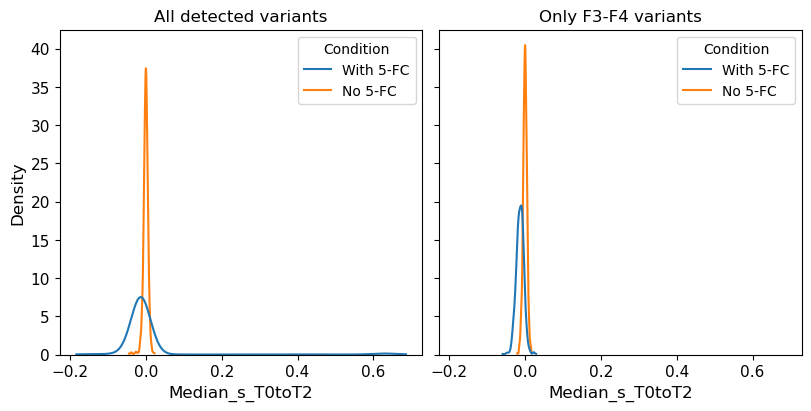

In [484]:
# Plotting the two distributions (of medians)
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True,
                       sharex=True, sharey=True)

# Left: All variants
sns.kdeplot(data=s_comp, x='Median_s_T0toT2', hue='Condition', ax=axs[0], cut=0)
axs[0].set_title('All detected variants')

# Right: Only F3F4 variants
s_comp_F3F4 = s_comp[s_comp['In F3F4'] == True].copy().reset_index(drop=True)
sns.kdeplot(data=s_comp_F3F4, x='Median_s_T0toT2', hue='Condition', ax=axs[1], cut=0)
axs[1].set_title('Only F3-F4 variants')

In [485]:
# What is the standard deviation of the "no 5-FC" distribution?
np.std(s_med_no5FC[s_med_no5FC['In F3F4'] == True].copy()['Median_s_T0toT2'])

0.005197575246539318

In [486]:
s_med_no5FC

Genotype  Position  In F3F4 Mutation type  Median_s_T0toT2  \
0     D-106_1nt_Gto-       106     True      Deletion        -0.003242   
1     D-107_1nt_Cto-       107     True      Deletion         0.004272   
2     D-108_1nt_Gto-       108     True      Deletion         0.002701   
3     D-109_1nt_Ato-       109     True      Deletion        -0.002043   
4     D-112_1nt_Tto-       112     True      Deletion         0.002762   
...              ...       ...      ...           ...              ...   
1082   S-98_1nt_TtoC        98     True  Substitution         0.006983   
1083   S-98_1nt_TtoG        98     True  Substitution        -0.002276   
1084   S-99_1nt_TtoA        99     True  Substitution        -0.001318   
1085   S-99_1nt_TtoC        99     True  Substitution        -0.001428   
1086   S-99_1nt_TtoG        99     True  Substitution        -0.000364   

         Min_s     Max_s  FCY1_position New_nt Condition  
0    -0.014697  0.016095            -99      -   No 5-FC  
1    -0.004959  0.010327            -98      -   No 5-FC  
2    -0.012937  0.008100            -97      -   No 5-FC  
3    -0.006665  0.005976            -96      -   No 5-FC  
4    -0.010413  0.011446            -93      -   No 5-FC  
...        ...       ...            ...    ...       ...  
1082 -0.006106  0.010981           -107      C   No 5-FC  
1083 -0.006408  0.009801           -107      G   No 5-FC  
1084 -0.015101  0.006531           -106      A   No 5-FC  
1085 -0.008256  0.005799           -106      C   No 5-FC  
1086 -0.004739  0.003330           -106      G   No 5-FC  

[1087 rows x 10 columns]

Testing if the two distributions are significantly different

In [488]:
# All variants
stats.ks_2samp(s_medians['Median_s_T0toT2'], s_med_no5FC['Median_s_T0toT2'])

KstestResult(statistic=0.6313916237676734, pvalue=1.2694947402842823e-207, statistic_location=-0.006828102514844, statistic_sign=1)

In [489]:
# F3F4 variants
stats.ks_2samp(s_medians[s_medians['In F3F4'] == True]['Median_s_T0toT2'], s_med_no5FC[s_med_no5FC['In F3F4'] == True]['Median_s_T0toT2'])

KstestResult(statistic=0.6686274509803921, pvalue=1.279312020270214e-216, statistic_location=-0.0057944152976127, statistic_sign=1)

In both cases, the distributions are significantly different! How can that be the case for the F3-F4 variants, if there are no measurable fitness effects? 

We see that the 5-FC distribution (for F3-F4 variants) is mostly shifted to the left. This could be explained by some rare beneficial secondary mutations going undetected and inflating the apparent fitness of the WT.

# For the CDS spike-ins libraries (only sequenced in 150 paired-end)

## Importing the final **filtered** selection coefficients:

In [494]:
s_filter_CDS = pd.read_csv("s_final/s_150_CDS_filtered.csv")
to_drop = ['s_T0toT1_Total', 's_T0toT2_Total', 's_T0toT3_Total', 'intercept_T0toT1_Total', 
           'intercept_T0toT2_Total', 'intercept_T0toT3_Total', 'ratio_T0toT1_Total',
           'ratio_T0toT2_Total', 'ratio_T0toT3_Total', 'intercept_T0toT3_Ref',
           'ratio_T0toT3_Ref', 's_T0toT1_Time', 's_T0toT2_Time', 's_T0toT3_Time', 
           'intercept_T0toT1_Time', 'intercept_T0toT2_Time', 'intercept_T0toT3_Time',
           'ratio_T0toT1_Time','ratio_T0toT2_Time','ratio_T0toT3_Time']
s_filter_CDS = s_filter_CDS.drop(columns=to_drop)

In [495]:
# Selecting only the data with 5-FC
s_CDS_5FC = s_filter_CDS[s_filter_CDS['Condition'] == 'WITH_5FC'].copy().reset_index(drop=True)

## Filtering potential outliers

### Computing medians, MADs and standard deviations

In [498]:
# Computing the median s for each genotype
s_medians_CDS = s_CDS_5FC[['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types',
                           'N_T0', 'N_T3', 's_T0toT1_Ref', 's_T0toT2_Ref',
                           's_T0toT3_Ref']].copy().groupby(by=['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types'], as_index=False).median()

s_medians_CDS = s_medians_CDS.rename(columns={'s_T0toT2_Ref': 'Median_s_T0toT2'})

In [499]:
# Preparing the dataframe for the MAD
s_MAD_CDS = s_CDS_5FC[['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types',
                       'Alias', 'Bio_rep', 'Tech_rep', 'N_T0', 'N_T3', 's_T0toT1_Ref', 's_T0toT2_Ref', 's_T0toT3_Ref']].copy()

# Adding the medians
s_MAD_CDS = pd.merge(s_MAD_CDS, s_medians_CDS[['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types', 'Median_s_T0toT2']],
                        on=['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types'], how='left')

# Computing the absolute deviation from the median, and then the MAD
s_MAD_CDS['Abs_med_s_T0toT2'] = np.abs(s_MAD_CDS['s_T0toT2_Ref'] - s_MAD_CDS['Median_s_T0toT2'])

s_MAD_calc = s_MAD_CDS[['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types', 'Abs_med_s_T0toT2']].copy()
s_MAD_calc = s_MAD_calc.groupby(by=['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types'], as_index=False).median()
s_MAD_calc = s_MAD_calc.rename(columns={'Abs_med_s_T0toT2': 'MAD_s_T0toT2'})
s_MAD_CDS = pd.merge(s_MAD_CDS, s_MAD_calc, on=['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types'], how='left')

# For each estimate, converting each abs deviation into a number of MADs
s_MAD_CDS['n_MAD'] = s_MAD_CDS['Abs_med_s_T0toT2'] / s_MAD_CDS['MAD_s_T0toT2']

In [500]:
# Adding the standard deviation to the df
s_std = s_CDS_5FC[['Genotype', 'Position (codon)', 'Included_position',
                   'In spike-in', 'Mutation types', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position (codon)',
                                                                                 'Included_position', 'In spike-in', 'Mutation types'], as_index=False).std()
s_std = s_std.rename(columns={'s_T0toT2_Ref': 'Std_s'})

s_min = s_CDS_5FC[['Genotype', 'Position (codon)', 'Included_position',
                   'In spike-in', 'Mutation types', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position (codon)',
                                                                                 'Included_position', 'In spike-in', 'Mutation types'], as_index=False).min()
s_min = s_min.rename(columns={'s_T0toT2_Ref': 'Min_s'})

s_max = s_CDS_5FC[['Genotype', 'Position (codon)', 'Included_position',
                   'In spike-in', 'Mutation types', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position (codon)',
                                                                                 'Included_position', 'In spike-in', 'Mutation types'], as_index=False).max()
s_max = s_max.rename(columns={'s_T0toT2_Ref': 'Max_s'})

s_bymut_CDS = pd.merge(s_std, s_min, on=['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types'], how='outer')
s_bymut_CDS = pd.merge(s_bymut_CDS, s_max, on=['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types'], how='outer')

### Looking at the distributions

1) Standard deviation by genotype

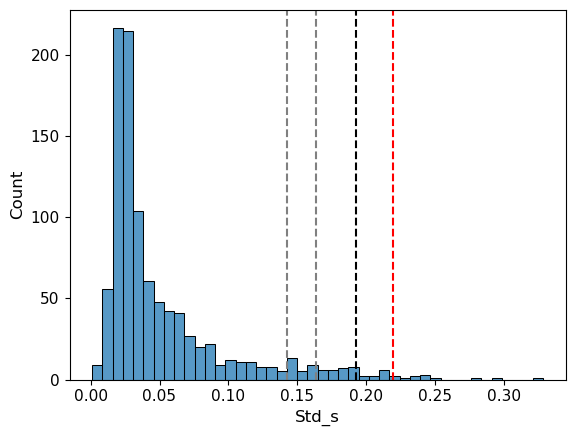

In [503]:
# Plotting the distribution of standard deviations, with 95th, 97.5th and 99th percentiles
std_925_CDS = np.nanpercentile(s_bymut_CDS['Std_s'], 92.5)
std_95_CDS = np.nanpercentile(s_bymut_CDS['Std_s'], 95)
std_975_CDS = np.nanpercentile(s_bymut_CDS['Std_s'], 97.5)
std_99_CDS = np.nanpercentile(s_bymut_CDS['Std_s'], 99)

sns.histplot(data=s_bymut_CDS, x='Std_s')
plt.axvline(x=std_925_CDS, linestyle='--', c='grey')
plt.axvline(x=std_95_CDS, linestyle='--', c='grey')
plt.axvline(x=std_975_CDS, linestyle='--', c='black')
plt.axvline(x=std_99_CDS, linestyle='--', c='red')

There seems to be outlier genotypes. The 95th percentile will be used as threshold.

2. nMAD by s estimate

In [506]:
# Computing 95th, 97.5 and 99 percentiles
n_MAD_95_CDS = np.nanpercentile(s_MAD_CDS['n_MAD'], 95)
n_MAD_975_CDS = np.nanpercentile(s_MAD_CDS['n_MAD'], 97.5)
n_MAD_99_CDS = np.nanpercentile(s_MAD_CDS['n_MAD'], 99)

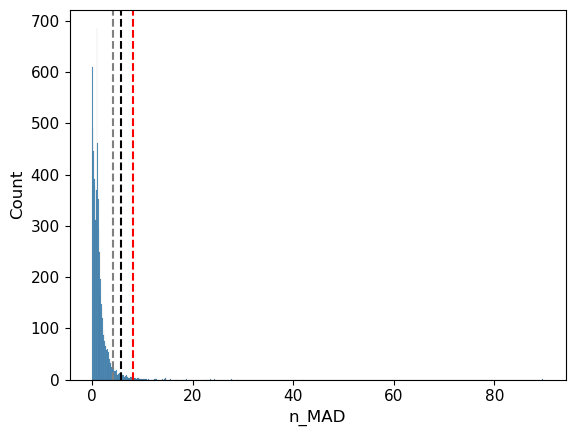

In [507]:
sns.histplot(data=s_MAD_CDS, x='n_MAD')
plt.axvline(x=n_MAD_95_CDS, linestyle='--', c='grey')
plt.axvline(x=n_MAD_975_CDS, linestyle='--', c='black')
plt.axvline(x=n_MAD_99_CDS, linestyle='--', c='red')

We definitely have some outliers! The 95th percentile will be used as threshold, again.

### Filtering out outlier measurements

Within genotypes with std >= 95th percentile, datapoints with nMAD >= 95th percentile are removed.

In [511]:
# Selecting genotypes on which the filtering must be applied
out_df_CDS = s_bymut_CDS[s_bymut_CDS['Std_s'] >= std_95_CDS].copy().reset_index(drop=True)
mut_to_filter_CDS = out_df_CDS['Genotype'].unique()

In [512]:
# Identifying the datapoints to remove
not_filtered_CDS =  s_MAD_CDS[~s_MAD_CDS['Genotype'].isin(mut_to_filter_CDS)].copy()
to_filter_CDS = s_MAD_CDS[s_MAD_CDS['Genotype'].isin(mut_to_filter_CDS)].copy()
to_filter_CDS['To_remove'] = to_filter_CDS['n_MAD'] > n_MAD_95_CDS

Plotting the outlier genotypes

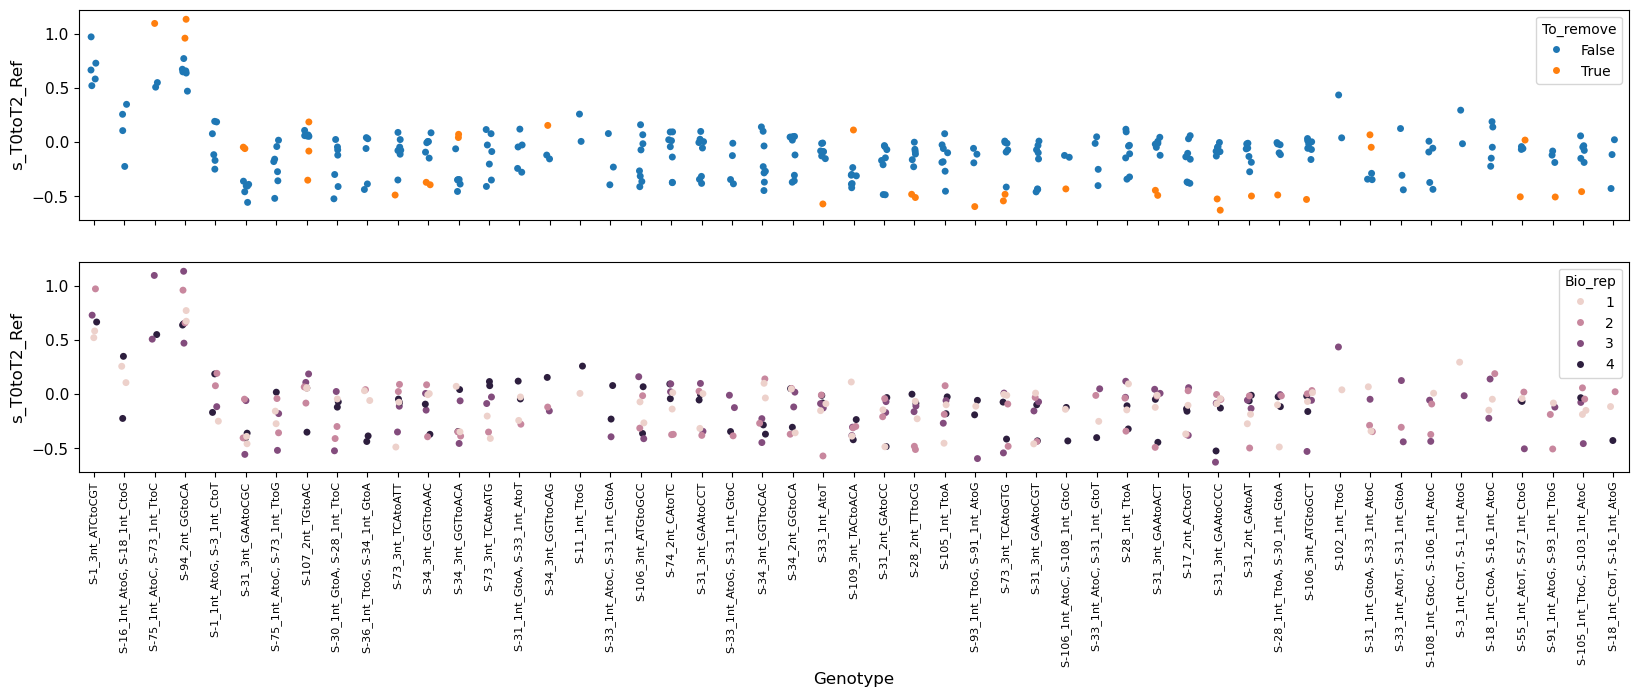

In [514]:
# All variants

fig, axs = plt.subplots(2, 1, figsize=(20, 6), sharex=True)
sns.stripplot(data=to_filter_CDS, x='Genotype', y='s_T0toT2_Ref', hue='To_remove', ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=90)

sns.stripplot(data=to_filter_CDS, x='Genotype', y='s_T0toT2_Ref', hue='Bio_rep', ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)

The relevance of this step seems much less obvious. What does the same graph look like when including only mutations which are part of the spike-in?

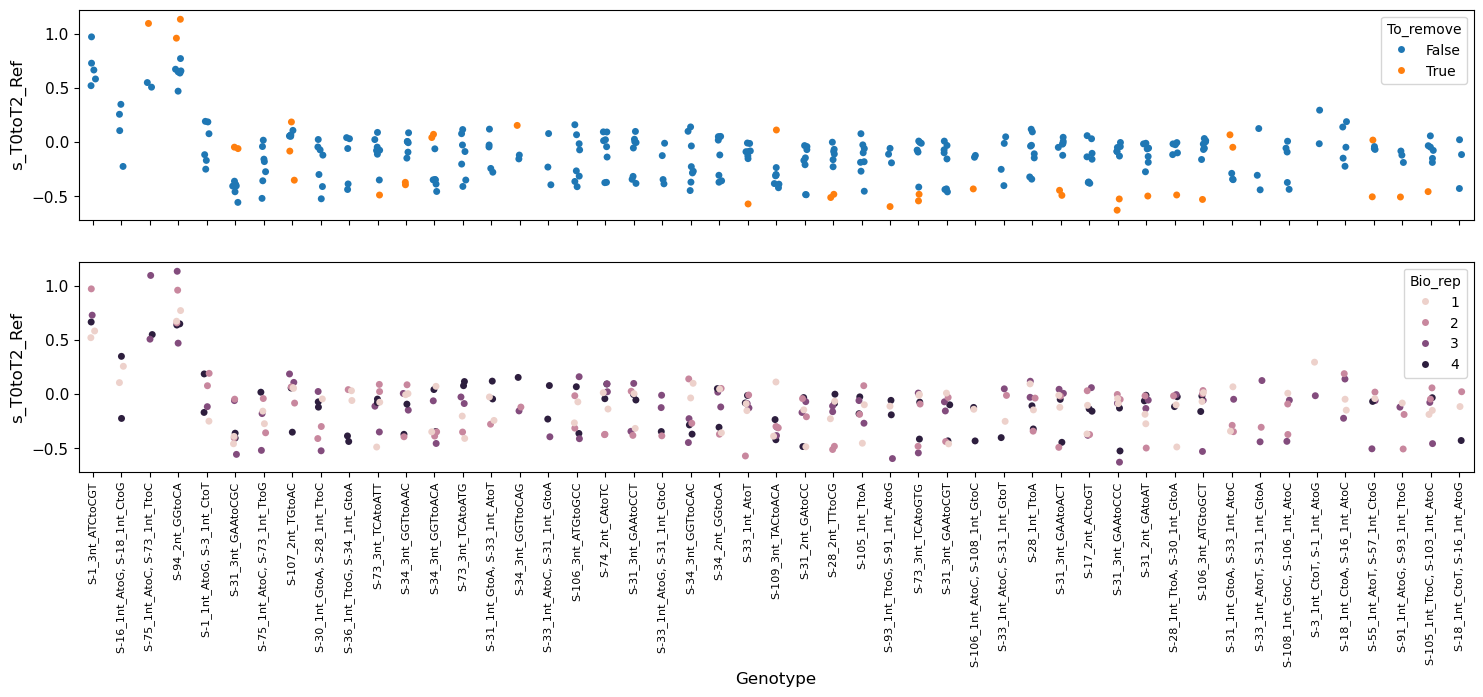

In [516]:
# Only mutations included in the spike-in (substitutions at the chosen codons)

to_filter_F3F4_CDS = to_filter_CDS[to_filter_CDS['In spike-in'] == True].copy().reset_index(drop=True)

fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharex=True)
sns.stripplot(data=to_filter_F3F4_CDS, x='Genotype', y='s_T0toT2_Ref', hue='To_remove', ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=90)

sns.stripplot(data=to_filter_F3F4_CDS, x='Genotype', y='s_T0toT2_Ref', hue='Bio_rep', ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)

The benefit of removing the outliers is not obvious here. They do not seem to be "biological artifacts", such as resistance-conferring secondary mutations, as previously. It will still be performed before testing how many mutations have significant fitness effects (!=0).

In [518]:
# Assembling the corresponding dataset without outliers
out_filtered_CDS = to_filter_CDS[to_filter_CDS['To_remove'] == False].copy().reset_index(drop=True)
out_filtered_CDS = out_filtered_CDS.drop(columns=['To_remove'])
s_no_out_CDS = pd.concat([not_filtered_CDS, out_filtered_CDS]).reset_index(drop=True)

### Testing how many fitness effects are significant

In [520]:
s_med_CDS = s_medians_CDS[s_medians_CDS['In spike-in'] == True].copy().reset_index(drop=True).drop(columns=['s_T0toT1_Ref', 's_T0toT3_Ref'])
s_CDS = s_no_out_CDS[s_no_out_CDS['In spike-in'] == True].copy().reset_index(drop=True)

In [521]:
# Adding min and max s to s_med_CDS
min_CDS = s_CDS[['Genotype', 'Position (codon)', 'Included_position',
                 'In spike-in', 'Mutation types', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position (codon)', 'Included_position',
                                                                               'In spike-in', 'Mutation types'], as_index=False).min()
min_CDS = min_CDS.rename(columns={'s_T0toT2_Ref': 'Min_s'})

max_CDS = s_CDS[['Genotype', 'Position (codon)', 'Included_position',
                 'In spike-in', 'Mutation types', 's_T0toT2_Ref']].groupby(by=['Genotype', 'Position (codon)', 'Included_position',
                                                                               'In spike-in', 'Mutation types'], as_index=False).max()
max_CDS = max_CDS.rename(columns={'s_T0toT2_Ref': 'Max_s'})

s_med_CDS = pd.merge(s_med_CDS, min_CDS, on=['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types'], how='outer')
s_med_CDS = pd.merge(s_med_CDS, max_CDS, on=['Genotype', 'Position (codon)', 'Included_position', 'In spike-in', 'Mutation types'], how='outer')

In [522]:
s_med_CDS['not_zero_p-val'] = np.nan
s_med_CDS['n_observed'] = np.nan

for row in range(s_med_CDS.shape[0]):
    current_mut = s_med_CDS.at[row, 'Genotype']
    data_subset = s_CDS[s_CDS['Genotype'] == current_mut].copy().reset_index(drop=True)
    n_obs = data_subset.shape[0]
    s_med_CDS.at[row, 'n_observed'] = n_obs
    t_test = stats.ttest_1samp(data_subset['s_T0toT2_Ref'], 0, nan_policy='omit')
    s_med_CDS.at[row, 'not_zero_p-val'] = t_test.pvalue

F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [523]:
s_med_CDS[s_med_CDS['not_zero_p-val'].isna()]

Genotype  Position (codon)  Included_position  \
2    S-103_1nt_AtoC, S-105_1nt_TtoC                99               True   
78   S-106_1nt_AtoG, S-108_1nt_GtoT               100               True   
204  S-111_1nt_CtoT, S-109_1nt_TtoG               101               True   
319    S-18_1nt_CtoA, S-16_1nt_AtoG                70               True   
442    S-28_1nt_TtoA, S-30_1nt_GtoT                74               True   
444    S-28_1nt_TtoC, S-30_1nt_GtoA                74               True   
645    S-55_1nt_AtoC, S-57_1nt_CtoT                83               True   
701    S-57_1nt_CtoG, S-55_1nt_AtoG                83               True   
715    S-73_1nt_TtoG, S-75_1nt_AtoC                89               True   
780    S-85_1nt_AtoG, S-87_1nt_GtoT                93               True   
844    S-91_1nt_AtoC, S-93_1nt_TtoG                95               True   
847    S-91_1nt_AtoG, S-93_1nt_TtoC                95               True   
854                 S-91_2nt_ACtoCG                95               True   
904    S-93_1nt_TtoC, S-91_1nt_AtoG                95               True   
968    S-96_1nt_TtoG, S-94_1nt_GtoT                96               True   

     In spike-in    Mutation types    N_T0     N_T3  Median_s_T0toT2  \
2           True  ['Substitution']  2042.0     25.0        -0.093381   
78          True  ['Substitution']  5153.0     38.0        -0.046959   
204         True  ['Substitution']  1650.0   6702.0         0.617035   
319         True  ['Substitution']  2811.0     15.0         0.024504   
442         True  ['Substitution']   134.0      3.0         0.000217   
444         True  ['Substitution']   502.0      1.0        -0.371520   
645         True  ['Substitution']   459.0   2728.0         0.605481   
701         True  ['Substitution']   654.0   1391.0         0.470632   
715         True  ['Substitution']   457.0      1.0        -0.381279   
780         True  ['Substitution']  4981.0  28209.0         0.641251   
844         True  ['Substitution']    33.0    154.0         0.492746   
847         True  ['Substitution']   237.0      1.0        -0.197481   
854         True  ['Substitution']    11.0    128.0         0.619934   
904         True  ['Substitution']   182.0      1.0        -0.298179   
968         True  ['Substitution']  1790.0  11415.0         0.593283   

        Min_s     Max_s  not_zero_p-val  n_observed  
2   -0.093381 -0.093381             NaN         1.0  
78  -0.046959 -0.046959             NaN         1.0  
204  0.617035  0.617035             NaN         1.0  
319  0.024504  0.024504             NaN         1.0  
442  0.000217  0.000217             NaN         1.0  
444 -0.371520 -0.371520             NaN         1.0  
645  0.605481  0.605481             NaN         1.0  
701  0.470632  0.470632             NaN         1.0  
715 -0.381279 -0.381279             NaN         1.0  
780  0.641251  0.641251             NaN         1.0  
844  0.492746  0.492746             NaN         1.0  
847 -0.197481 -0.197481             NaN         1.0  
854  0.619934  0.619934             NaN         1.0  
904 -0.298179 -0.298179             NaN         1.0  
968  0.593283  0.593283             NaN         1.0

In [524]:
# Dropping NaNs for the Benjamini-Hochberg correction
s_med_na = s_med_CDS[s_med_CDS['not_zero_p-val'].isna()].copy().reset_index(drop=True)
s_med_CDS = s_med_CDS.dropna(subset=['not_zero_p-val']).reset_index(drop=True)
s_med_CDS['not_zero_FDR'] = stats.false_discovery_control(s_med_CDS['not_zero_p-val'])

In [525]:
s_med_CDS[s_med_CDS['not_zero_FDR'] < 0.05].shape[0]

759

Among the ~1000 CDS mutants selected, 759 have a significant effect on fitness!

In [527]:
s_med_CDS[s_med_CDS['not_zero_FDR'] < 0.05].sort_values(by='Median_s_T0toT2')

Genotype  Position (codon)  Included_position  \
530             S-31_3nt_GAAtoCGC                75               True   
585             S-34_3nt_GGTtoACA                76               True   
154            S-109_3nt_TACtoACA               101               True   
501  S-31_1nt_GtoA, S-33_1nt_AtoC                75               True   
721             S-73_3nt_TCAtoATC                89               True   
..                            ...               ...                ...   
728             S-73_3nt_TCAtoCGG                89               True   
950  S-96_1nt_TtoC, S-94_1nt_GtoC                96               True   
907               S-94_2nt_GGtoCA                96               True   
394              S-1_3nt_ATCtoCGT                65               True   
387              S-1_3nt_ATCtoCAG                65               True   

     In spike-in    Mutation types    N_T0     N_T3  Median_s_T0toT2  \
530         True  ['Substitution']   603.0      1.0        -0.397646   
585         True  ['Substitution']   397.5      1.0        -0.346975   
154         True  ['Substitution']  4316.0      9.5        -0.308583   
501         True  ['Substitution']   201.0      1.0        -0.288537   
721         True  ['Substitution']   156.5      1.0        -0.245246   
..           ...               ...     ...      ...              ...   
728         True  ['Substitution']  1662.5  12489.5         0.645423   
950         True  ['Substitution']   431.5   3913.0         0.659964   
907         True  ['Substitution']    21.0    203.0         0.665893   
394         True  ['Substitution']    48.0    193.0         0.666279   
387         True  ['Substitution']    16.5    297.5         0.760848   

        Min_s     Max_s  not_zero_p-val  n_observed  not_zero_FDR  
530 -0.556909 -0.361033    2.344227e-05         6.0  4.141468e-05  
585 -0.456042 -0.061975    2.035977e-03         6.0  3.112695e-03  
154 -0.421685 -0.235131    9.720676e-06         7.0  1.774955e-05  
501 -0.346913 -0.288537    3.294875e-03         3.0  4.919109e-03  
721 -0.338655  0.136786    6.700274e-03         8.0  9.568955e-03  
..        ...       ...             ...         ...           ...  
728  0.613132  0.669885    9.026384e-12         8.0  7.423423e-11  
950  0.651993  0.667935    7.688445e-03         2.0  1.085026e-02  
907  0.470912  0.772199    1.647086e-05         6.0  2.948067e-05  
394  0.521514  0.972652    8.777792e-04         5.0  1.407397e-03  
387  0.633341  0.910144    1.643724e-03         4.0  2.553930e-03  

[759 rows x 13 columns]

Considering the expression-fitness function which we have measured experimentally, it is unlikely that the deleterious effects which are significant are real. They are probably artifacts related to secondary mutations in the WT.  

## Exporting the selection coefficient estimates for CDS mutations in 5-FC

In [530]:
s_med_CDS = pd.concat([s_med_CDS, s_med_na])

In [531]:
# Median s for F3F4 mutations, with p-values (t-test to see if diff from 0)
s_med_CDS.to_csv("Supp_data/median_s_CDS.csv", index=False)

# Final data, per library (only 5-FC and no spike-ins)
s_no_out_CDS.to_csv("Supp_data/s_150_CDS_5FC_no_out.csv", index=False)

## Saving figures S10 and S11

### S10 Fig

In [534]:
# Renaming columns
to_filter_F3F4 = to_filter_F3F4.rename(columns={'To_remove': 'Removed', 'Bio_rep': 'Transformation'})

# Changing True/False For Yes/No
to_filter_F3F4['Removed'] = to_filter_F3F4['Removed'].apply(lambda x: 'Yes' if x else 'No')

In [535]:
# Renaming the genotypes
for row in to_filter_F3F4.index:
    current_mut = to_filter_F3F4.at[row, 'Genotype']
    mut_type = current_mut[0]
    position = int(current_mut.split('_')[0].split('-')[1])
    mut_char = current_mut.split('_')[2]

    if mut_type == 'I':
        new_pos = position + 1 - 205
    else:
        new_pos = position - 205

    new_mut = f'{mut_type}_{new_pos}_{mut_char}'
    to_filter_F3F4.at[row, 'Fig_genotype'] = new_mut

In [536]:
to_filter_F3F4

Genotype  Position  In F3F4 Mutation type  Alias  Transformation  \
0    S-143_1nt_AtoG       143     True  Substitution     19               4   
1    I-192_1nt_-toC       192     True     Insertion     19               4   
2    I-118_1nt_-toC       118     True     Insertion     19               4   
3    S-151_1nt_GtoA       151     True  Substitution     19               4   
4    S-126_1nt_TtoG       126     True  Substitution     19               4   
..              ...       ...      ...           ...    ...             ...   
141   S-78_1nt_GtoA        78     True  Substitution     16               3   
142  I-203_1nt_-toG       203     True     Insertion     16               3   
143  S-143_1nt_AtoG       143     True  Substitution     16               3   
144   S-80_1nt_GtoT        80     True  Substitution     16               3   
145  I-109_1nt_-toT       109     True     Insertion     16               3   

    Tech_rep  To_ignore  N_T0   N_T3  s_T0toT1_Ref  s_T0toT2_Ref  \
0          B      False   305  550.0      0.045256      0.154763   
1          B      False   383   26.0     -0.005086     -0.028095   
2          B      False   175    4.0     -0.021082      0.005755   
3          B      False   132  149.0      0.053266      0.161020   
4          B      False   291   13.0      0.005773      0.015201   
..       ...        ...   ...    ...           ...           ...   
141        A       True   555   25.0     -0.024981     -0.033572   
142        A       True   300    2.0      0.030926     -0.031700   
143        A       True   259   16.0     -0.038268     -0.044675   
144        A       True   380   32.0     -0.003388     -0.015545   
145        A       True   387    9.0     -0.028264     -0.037184   

     s_T0toT3_Ref  Median_s_T0toT2  Abs_med_s_T0toT2  MAD_s_T0toT2      n_MAD  \
0        0.255875        -0.004311          0.159075      0.037310   4.263577   
1        0.010052        -0.028095          0.000000      0.039359   0.000000   
2       -0.046258        -0.043616          0.049371      0.049371   1.000000   
3        0.227860        -0.014307          0.175327      0.012646  13.863720   
4       -0.005244        -0.002687          0.017888      0.011719   1.526421   
..            ...              ...               ...           ...        ...   
141     -0.069670        -0.000351          0.033222      0.018108   1.834652   
142     -0.192804        -0.025451          0.006250      0.011352   0.550517   
143     -0.051854        -0.004311          0.040363      0.037310   1.081830   
144     -0.028364         0.001777          0.017322      0.025705   0.673859   
145     -0.111106        -0.020587          0.016597      0.016209   1.023963   

    Removed Fig_genotype  
0       Yes   S_-62_AtoG  
1        No   I_-12_-toC  
2        No   I_-86_-toC  
3       Yes   S_-54_GtoA  
4        No   S_-79_TtoG  
..      ...          ...  
141      No  S_-127_GtoA  
142      No    I_-1_-toG  
143      No   S_-62_AtoG  
144      No  S_-125_GtoT  
145      No   I_-95_-toT  

[146 rows x 19 columns]

In [537]:
to_filter_F3F4 = to_filter_F3F4.rename(columns={'Transformation replicate': 'Transformation'})

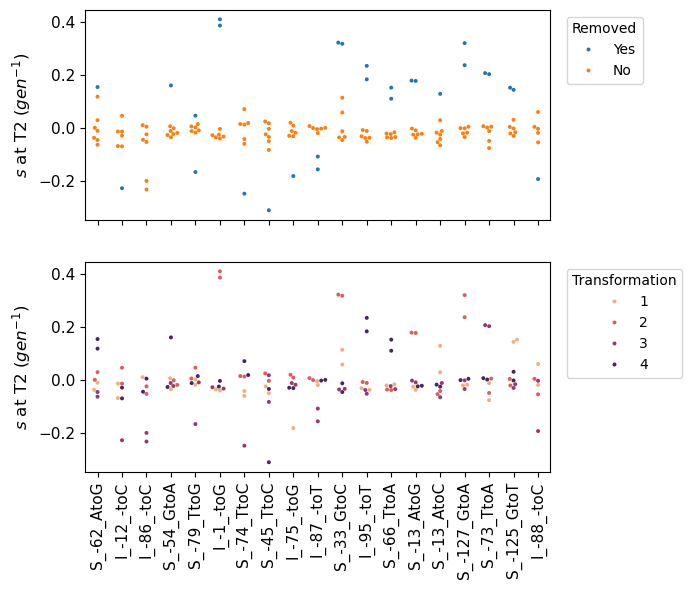

In [538]:
# S10 Fig: Removal of outliers for 
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams['savefig.dpi'] = 600


fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
removed = sns.swarmplot(data=to_filter_F3F4, x='Fig_genotype', y='s_T0toT2_Ref', hue='Removed', size=2.85, ax=axs[0])
sns.move_legend(removed, "upper left", bbox_to_anchor=(1.02, 1))
axs[0].set_ylabel(r"$s$ at T2 ($gen^{-1}$)")

transfos = sns.swarmplot(data=to_filter_F3F4, x='Fig_genotype', y='s_T0toT2_Ref', hue='Transformation', size=2.85, ax=axs[1], palette='flare')
axs[1].tick_params(axis='x', labelrotation=90)
axs[1].set_xlabel('')
sns.move_legend(transfos, "upper left", bbox_to_anchor=(1.02, 1))
axs[1].set_ylabel(r"$s$ at T2 ($gen^{-1}$)")

FigS10 = plt.gcf()
FigS10.savefig('Supp_figs/S10Fig.tiff', bbox_inches='tight')

In [539]:
to_filter_F3F4

Genotype  Position  In F3F4 Mutation type  Alias  Transformation  \
0    S-143_1nt_AtoG       143     True  Substitution     19               4   
1    I-192_1nt_-toC       192     True     Insertion     19               4   
2    I-118_1nt_-toC       118     True     Insertion     19               4   
3    S-151_1nt_GtoA       151     True  Substitution     19               4   
4    S-126_1nt_TtoG       126     True  Substitution     19               4   
..              ...       ...      ...           ...    ...             ...   
141   S-78_1nt_GtoA        78     True  Substitution     16               3   
142  I-203_1nt_-toG       203     True     Insertion     16               3   
143  S-143_1nt_AtoG       143     True  Substitution     16               3   
144   S-80_1nt_GtoT        80     True  Substitution     16               3   
145  I-109_1nt_-toT       109     True     Insertion     16               3   

    Tech_rep  To_ignore  N_T0   N_T3  s_T0toT1_Ref  s_T0toT2_Ref  \
0          B      False   305  550.0      0.045256      0.154763   
1          B      False   383   26.0     -0.005086     -0.028095   
2          B      False   175    4.0     -0.021082      0.005755   
3          B      False   132  149.0      0.053266      0.161020   
4          B      False   291   13.0      0.005773      0.015201   
..       ...        ...   ...    ...           ...           ...   
141        A       True   555   25.0     -0.024981     -0.033572   
142        A       True   300    2.0      0.030926     -0.031700   
143        A       True   259   16.0     -0.038268     -0.044675   
144        A       True   380   32.0     -0.003388     -0.015545   
145        A       True   387    9.0     -0.028264     -0.037184   

     s_T0toT3_Ref  Median_s_T0toT2  Abs_med_s_T0toT2  MAD_s_T0toT2      n_MAD  \
0        0.255875        -0.004311          0.159075      0.037310   4.263577   
1        0.010052        -0.028095          0.000000      0.039359   0.000000   
2       -0.046258        -0.043616          0.049371      0.049371   1.000000   
3        0.227860        -0.014307          0.175327      0.012646  13.863720   
4       -0.005244        -0.002687          0.017888      0.011719   1.526421   
..            ...              ...               ...           ...        ...   
141     -0.069670        -0.000351          0.033222      0.018108   1.834652   
142     -0.192804        -0.025451          0.006250      0.011352   0.550517   
143     -0.051854        -0.004311          0.040363      0.037310   1.081830   
144     -0.028364         0.001777          0.017322      0.025705   0.673859   
145     -0.111106        -0.020587          0.016597      0.016209   1.023963   

    Removed Fig_genotype  
0       Yes   S_-62_AtoG  
1        No   I_-12_-toC  
2        No   I_-86_-toC  
3       Yes   S_-54_GtoA  
4        No   S_-79_TtoG  
..      ...          ...  
141      No  S_-127_GtoA  
142      No    I_-1_-toG  
143      No   S_-62_AtoG  
144      No  S_-125_GtoT  
145      No   I_-95_-toT  

[146 rows x 19 columns]

### S11 Fig

In [541]:
# Combining all selection coefficients with and without 5-FC (keepin sample ids)
FC_to_comp = s_no_out[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'Bio_rep', 'Tech_rep',
                      's_T0toT2_Ref']].copy()
FC_to_comp['samp_id'] = FC_to_comp['Bio_rep'].astype('str') + FC_to_comp['Tech_rep']
FC_to_comp['Condition'] = '5-FC'

no_to_comp = s_no_5FC[['Genotype', 'Position', 'In F3F4', 'Mutation type', 'Bio_rep', 'Tech_rep',
                      's_T0toT2_Ref']].copy()
# Samples with spike-ins have already been removed
no_to_comp['samp_id'] = no_to_comp['Bio_rep'].astype('str') + no_to_comp['Tech_rep']
no_to_comp['Condition'] = 'No 5-FC'

s_fig_comp = pd.concat([FC_to_comp, no_to_comp]).reset_index(drop=True)

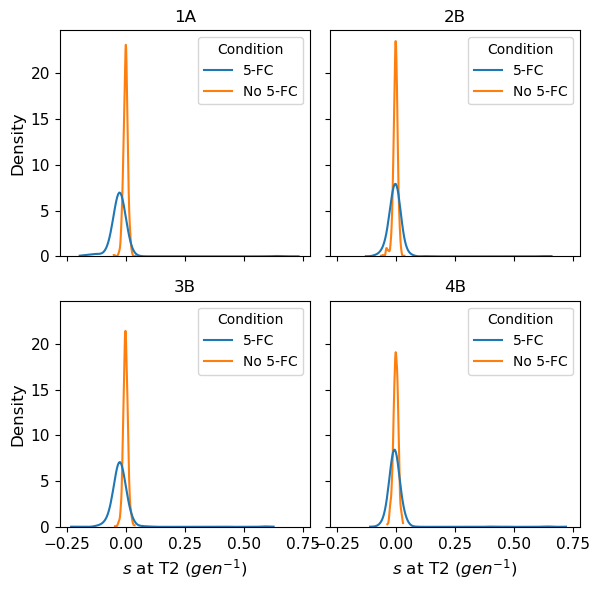

In [542]:
# Making the figure
fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)

order_samp = ['1A', '2B', '3B', '4B']
ax_row = 0
ax_col = 0

for fig_num in range(4):
    lib_id = order_samp[fig_num]
    data_subset = s_fig_comp[s_fig_comp['samp_id'] == lib_id].copy().reset_index(drop=True)
    sns.kdeplot(data=data_subset, x='s_T0toT2_Ref', hue='Condition', ax=axs[ax_row, ax_col], cut=0)
    axs[ax_row, ax_col].set_title(f'{lib_id}')

    if ax_col == 1:
        ax_row += 1
        ax_col = 0
    else:
        ax_col += 1

axs[1,0].set_xlabel(r"$s$ at T2 ($gen^{-1}$)")
axs[1,1].set_xlabel(r"$s$ at T2 ($gen^{-1}$)")

plt.tight_layout()

FigS11 = plt.gcf()
FigS11.savefig('Supp_figs/S11Fig.tiff', bbox_inches='tight')

### S13B Fig

Redoing the comparison between samples with and without spike-ins, for the F3-F4 pools

In [545]:
# Adding a column identifying F3-F4 and CDS variants (and removing secondary mutations in the promoter)
medians_merged = medians_merged[medians_merged['FCY1_position'] >= -153].copy().reset_index(drop=True)
medians_merged['Type of variant'] = medians_merged['In F3F4'].apply(lambda x: 'F3F4' if x else 'CDS')

In [546]:
medians_merged.sort_values(by=['Median_s_T0toT2_Spikes'], ascending=False)

Genotype  Position  In F3F4 Mutation type  Median_s_T0toT2  \
79   D-240_1nt_Ato-       240    False      Deletion         0.629821   
84   D-248_1nt_Ato-       248    False      Deletion         0.621853   
76   D-229_1nt_Cto-       229    False      Deletion         0.627757   
81   D-242_1nt_Ato-       242    False      Deletion         0.596116   
437  I-222_1nt_-toG       222    False     Insertion         0.610566   
..              ...       ...      ...           ...              ...   
948  S-298_1nt_TtoA       298    False  Substitution        -0.018911   
949  S-298_1nt_TtoG       298    False  Substitution        -0.048565   
951  S-300_1nt_CtoA       300    False  Substitution        -0.126700   
954  S-309_1nt_GtoT       309    False  Substitution        -0.165322   
955  S-314_1nt_CtoA       314    False  Substitution        -0.053465   

     Median_s_ignored  Min_s_ignored  Max_s_ignored  FCY1_position New_nt  \
79           0.629821       0.620129       0.639514             35      -   
84                NaN            NaN            NaN             43      -   
76           0.627757       0.602654       0.652860             24      -   
81                NaN            NaN            NaN             37      -   
437               NaN            NaN            NaN             18      G   
..                ...            ...            ...            ...    ...   
948               NaN            NaN            NaN             93      A   
949         -0.058447      -0.080358      -0.036535             93      G   
951               NaN            NaN            NaN             95      A   
954               NaN            NaN            NaN            104      T   
955          0.018430       0.018430       0.018430            109      A   

    To_ignore  Median_s_T0toT2_Spikes     Min_s     Max_s Type of variant  
79      False                0.871807  0.861555  0.882059             CDS  
84      False                0.818582  0.619814  1.017350             CDS  
76      False                0.812152  0.752852  0.871452             CDS  
81      False                0.762584  0.762584  0.762584             CDS  
437     False                0.731816  0.731816  0.731816             CDS  
..        ...                     ...       ...       ...             ...  
948       NaN                     NaN       NaN       NaN             CDS  
949       NaN                     NaN       NaN       NaN             CDS  
951       NaN                     NaN       NaN       NaN             CDS  
954       NaN                     NaN       NaN       NaN             CDS  
955       NaN                     NaN       NaN       NaN             CDS  

[1104 rows x 15 columns]

In [547]:
# Preparing another version of the dataframe for violinplots
medians_violins = pd.melt(medians_merged[['Genotype', 'Median_s_ignored', 'Median_s_T0toT2_Spikes', 'Type of variant']].copy(),
                         id_vars=['Genotype', 'Type of variant'], value_vars=['Median_s_ignored', 'Median_s_T0toT2_Spikes'],
                         value_name='Median s', var_name='Libraries')
# Reformatting the libraries column
lib_type_dict = {'Median_s_ignored': 'Only F3F4', 'Median_s_T0toT2_Spikes': 'With CSM'}
medians_violins['Libraries'] = medians_violins['Libraries'].apply(lambda x: lib_type_dict[x])

In [548]:
medians_violins

Genotype Type of variant  Libraries  Median s
0     D-106_1nt_Gto-            F3F4  Only F3F4 -0.012988
1     D-107_1nt_Cto-            F3F4  Only F3F4  0.000058
2     D-108_1nt_Gto-            F3F4  Only F3F4 -0.003902
3     D-109_1nt_Ato-            F3F4  Only F3F4 -0.022063
4     D-112_1nt_Tto-            F3F4  Only F3F4  0.009886
...              ...             ...        ...       ...
2203   S-98_1nt_TtoC            F3F4   With CSM -0.051742
2204   S-98_1nt_TtoG            F3F4   With CSM  0.001145
2205   S-99_1nt_TtoA            F3F4   With CSM -0.011340
2206   S-99_1nt_TtoC            F3F4   With CSM  0.027618
2207   S-99_1nt_TtoG            F3F4   With CSM  0.009151

[2208 rows x 4 columns]

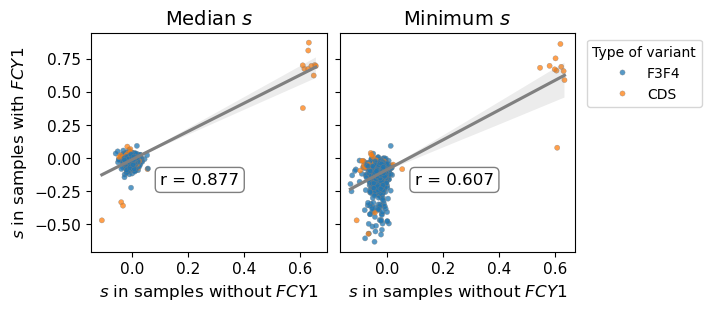

In [549]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True, sharey=True)

#violins_s = sns.violinplot(data=medians_violins[medians_violins['Var_type'] == 'F3F4'], x='Libraries', y='Median s',
                           #hue='Var_type', ax=axs[0], cut=0, alpha=0.95, edgecolor='grey', legend=False)

sns.scatterplot(data=medians_merged, x='Median_s_ignored', y='Median_s_T0toT2_Spikes', hue='Type of variant', ax=axs[0], edgecolor='grey', s=14,
                alpha=0.75, legend=False)
sns.regplot(data=medians_merged, x='Median_s_ignored', y='Median_s_T0toT2_Spikes', ax=axs[0], color='grey', scatter=False)
calc_1 = medians_merged.dropna(subset=['Median_s_ignored', 'Median_s_T0toT2_Spikes']).reset_index(drop=True)
pearson_1 = stats.pearsonr(calc_1['Median_s_ignored'], calc_1['Median_s_T0toT2_Spikes'])
axs[0].annotate(r"r = "f'{round(pearson_1[0], 3)}',
                (0.1, -0.2), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)
axs[0].set_title(r"Median $s$", fontsize=14)
axs[0].set_ylabel(r"$s$ in samples with $\it{FCY1}$")
axs[0].set_xlabel(r"$s$ in samples without $\it{FCY1}$")

scatter_min = sns.scatterplot(data=medians_merged, x='Min_s_ignored', y='Min_s', hue='Type of variant', ax=axs[1], edgecolor='grey', s=14, alpha=0.75)
sns.regplot(data=medians_merged, x='Min_s_ignored', y='Min_s', ax=axs[1], color='grey', scatter=False)
calc_2 = medians_merged.dropna(subset=['Min_s_ignored', 'Min_s']).reset_index(drop=True)
pearson_2 = stats.pearsonr(calc_2['Min_s_ignored'], calc_2['Min_s'])
axs[1].annotate(r"r = "f'{round(pearson_2[0], 3)}',
                (0.1, -0.2), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)
sns.move_legend(scatter_min, "upper left", bbox_to_anchor=(1.02, 1))
axs[1].set_title(r"Minimum $s$", fontsize=14)
axs[1].set_xlabel(r"$s$ in samples without $\it{FCY1}$")

FigS13B = plt.gcf()
FigS13B.savefig('Supp_figs/S13BFig.tiff', bbox_inches='tight')